# Direct Least Squares Reconstruction (DLSR) for XRD-CT Using PyTorch

## 📝 Introduction

This notebook provides the **first open-source implementation** of the Direct Least Squares Reconstruction (DLSR) method for X-ray diffraction computed tomography (XRD-CT), implemented entirely in Python using PyTorch with GPU acceleration.

Originally developed and validated using the TOPAS software, DLSR was introduced to solve the **parallax artefact** in XRD-CT (see Vamvakeros et al., J. Appl. Cryst., 53, 1531-1541, 2020, https://doi.org/10.1107/S1600576720013576) — a distortion that arises from the depth-dependent shift of Bragg peaks during pencil-beam scanning. Unlike filtered back projection (FBP), which reconstructs image intensities and then fits peaks post hoc, DLSR inverts the full forward model directly in **parameter space** (e.g., peak position, width, amplitude, background), yielding artefact-free maps in a single optimisation step.

Here, we extend the original work by:
- Providing a **fully open-source PyTorch-based implementation**
- Introducing a **neural network model** in place of voxel-wise parameter maps
- Demonstrating improved performance under angular undersampling conditions

## 🎯 Objectives

By the end of this notebook, you will:
- Understand the principle of DLSR and how it differs from conventional FBP-based pipelines
- See how a neural network can be trained to directly reconstruct physical parameter maps from sinogram data
- Compare the results of DLSR to FBP followed by post-reconstruction peak fitting
- Evaluate the robustness of DLSR in cases of angular undersampling (e.g. few projection angles)

## 🧪 Why DLSR?

In conventional XRD-CT workflows:
1. The sinogram is reconstructed (e.g. via FBP)
2. Each voxel's spectrum is then peak-fitted individually

This approach introduces errors if peak shapes or positions are misrepresented due to reconstruction artefacts (especially under parallax or sparse-angle sampling).

**DLSR bypasses this problem** by:
- Treating peak parameters as the direct image to be reconstructed
- Using the known physical forward model to generate sinograms from these parameters
- Optimising parameter values by minimizing the difference between synthetic and experimental sinograms

## 📦 Dataset & Setup

This notebook uses synthetic data representing a 2D phantom with spatially varying peak parameters. The volume is forward-projected to create a sinogram, to which Poisson noise is added.

We then:
- Train a PyTorch model to reconstruct the parameter maps directly from the sinogram
- Compare DLSR output against conventional FBP + peak fitting
- Explore reconstruction accuracy under angular undersampling

Let’s begin by importing the relevant packages and generating the dataset.

## 🧪 Generate Synthetic XRD-CT Phantom and 3D Hyperspectral Volume

We begin by constructing a synthetic 2D spatial phantom composed of five components. These spatial maps (`im1`–`im5`) are used to define the spatially varying parameters of a single diffraction peak with linear background.

### 🏗️ Steps:

1. **Define the diffraction domain**:
   - The variable `x` represents the diffraction axis (e.g., 2θ or q-space), sampled from 0 to 5 in steps of 0.25.

2. **Assign parameter ranges**:
   - `peak_area`, `peak_position`, and `peak_fwhm` define the Gaussian peak.
   - `peak_slope` and `peak_intercept` define the background.
   - Each parameter is mapped from a phantom image and scaled linearly within its physical range.

3. **Construct the volume**:
   - A full 3D volume `vol` is generated where each voxel contains a 1D spectrum (Gaussian + linear background).
   - Padding is applied around the spatial edges to avoid artefacts at boundaries.

4. **Prepare for forward projection**:
   - The volume is reshaped and converted into a PyTorch tensor (`yobs`) on the GPU.
   - Tensor dimensions are permuted into the expected format: `(batch, channels, height, width)`.

This synthetic dataset represents an ideal, ground-truth volume. It will later be forward-projected to simulate sinograms for DLSR training and evaluation.

c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\anton\anaconda3\envs\ndtomo\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorith

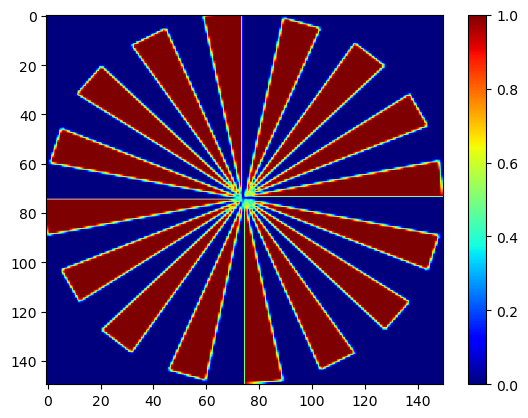

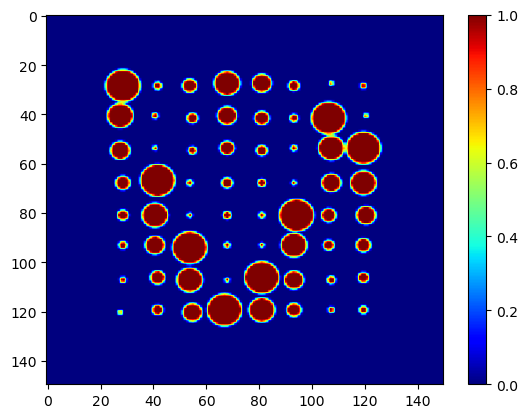

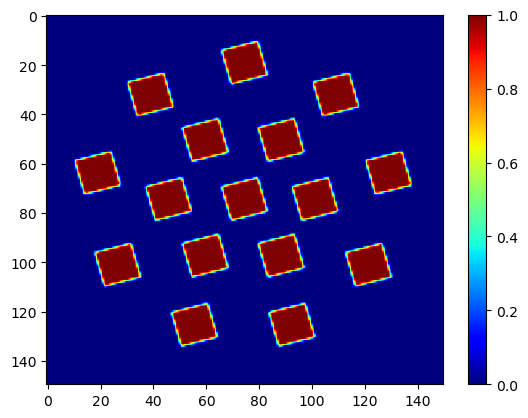

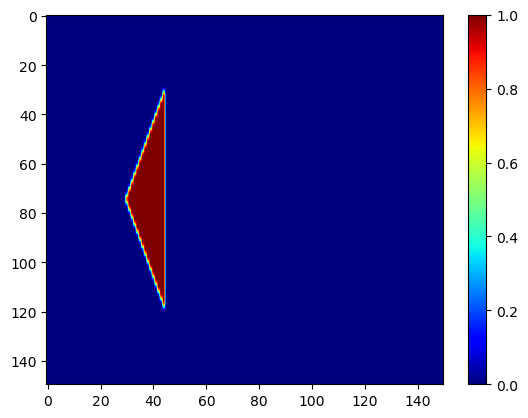

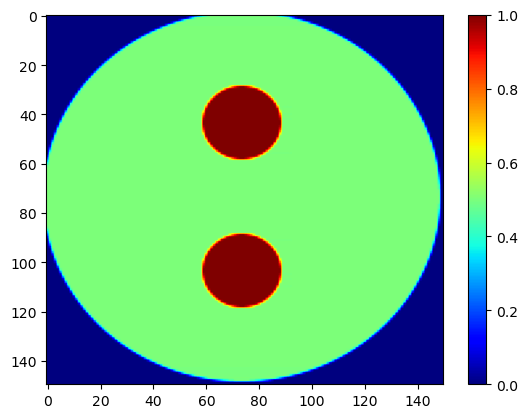

100%|██████████| 150/150 [00:00<00:00, 665.95it/s]


(160, 160, 20) 1.5
torch.Size([1, 20, 160, 160])


In [1]:

from nDTomo.sim.phantoms import load_example_patterns, nDTomophantom_2D, nDTomophantom_3D
from nDTomo.methods.plots import showspectra, showim
from nDTomo.methods.noise import addpnoise3D
from nDTomo.pytorch.tomo_torch import forward_project_3D
from nDTomo.pytorch.models_torch import PeakFitCNN, PrmCNN2D
from nDTomo.pytorch.utils_torch import calc_patches_indices, denormalize, filter_patch_indices, update_counter, initialize_counter, calc_patches_indices

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch, time
import torch.nn.functional as F
from torch import nn

# Create 2D spatial images for the five components
npix = 150
im1, im2, im3, im4, im5 = nDTomophantom_2D(npix, nim='Multiple')
iml = [im1, im2, im3, im4, im5]

im5 = im5/np.max(im5)

%matplotlib inline

# Optionally display spatial maps
showim(im1, 2)
showim(im2, 3)
showim(im3, 4)
showim(im4, 5)
showim(im5, 6)


def linear_background(x, slope, intercept):
    return slope*x + intercept

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2*sigma**2))

# Define the x axis
x = np.arange(0, 5, 0.25)

# Define the min/max for the various parameters

peak1_mu_min = 2
peak1_mu_max = 3

peak1_sigma_min = 0.2
peak1_sigma_max = 0.4

peak1_A_min = 0
peak1_A_max = 1.25

bkg_slope_min = 0.0
bkg_slope_max = 0.025

bkg_intercept_min = 0.05
bkg_intercept_max = 0.25

im6 = im2 + im5
im6 = im6 / np.max(im6)

peak_area = peak1_A_min + im6*(peak1_A_max - peak1_A_min)
peak_position = peak1_mu_min + im2*(peak1_mu_max - peak1_mu_min)
peak_fwhm = peak1_sigma_min + im3*(peak1_sigma_max - peak1_sigma_min)
peak_slope = bkg_slope_min + im4*(bkg_slope_max - bkg_slope_min)
peak_intercept = bkg_intercept_min + im5*(bkg_intercept_max - bkg_intercept_min)

vol = np.zeros((im1.shape[0], im1.shape[1], len(x)), dtype = 'float32')

mask_tmp = np.copy(peak_area)
mask_tmp[mask_tmp<0.0001] = 0
mask_tmp[mask_tmp>0] = 1

for ii in tqdm(range(im1.shape[0])):
    for jj in range(im1.shape[1]):
        if mask_tmp[ii,jj] > 0:
            vol[ii,jj,:] = gaussian(x, A=peak_area[ii,jj], mu=peak_position[ii,jj], sigma=peak_fwhm[ii,jj]) + \
                           linear_background(x, slope=peak_slope[ii,jj], intercept=peak_intercept[ii,jj])

extra = 5
vol = np.concatenate((np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32'), vol, np.zeros((vol.shape[0], extra, len(x)), dtype = 'float32')), axis=1)
vol = np.concatenate((np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32'), vol, np.zeros((extra, vol.shape[1], len(x)), dtype = 'float32')), axis=0)

print(vol.shape, np.max(vol))

volp = np.copy(vol)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device='cuda')
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)#[0,:,:,:]
print(yobs.shape)


## 📡 Forward Project Synthetic Volume to Generate Noisy Sinogram

In this step, we simulate the **experimental acquisition process** by projecting the 3D synthetic volume onto a set of projection angles, thereby generating a sinogram volume. This sinogram volume will serve as the input to both the DLSR and FBP-based reconstruction pipelines.

### 🔧 Forward Projection

- The `forward_project_3D()` function computes parallel-beam projections of the hyperspectral volume (`yobs`) for a specified set of angles.
- Each projection corresponds to a linear integral along a direction in the `(x, y)` plane, for each spectral channel.

Here we simulate:
- A **sparse angular acquisition** using only `60` projection angles between 0° and 180° (undersampled regime) for a sample that consists of `150` voxels in along one dimension (i.e. images consisting of `150` x `150` voxels)
- This mimics realistic conditions where scan time or radiation dose must be minimized.

### 🌫️ Add Poisson Noise

- Poisson noise is added to the sinogram (`sn`) using `addpnoise3D()` to emulate photon-counting statistics at moderate exposure (`ct=100`).

### 🔁 FBP Baseline (for Comparison)

- As a baseline, we apply **Filtered Back Projection (FBP)** to the noisy sinogram using `astra_rec_vol()`.
- This yields a reconstructed hyperspectral volume (`r`) from which conventional peak fitting will be performed later.

This step prepares both the noisy sinogram and its conventional reconstruction, which will serve as inputs for downstream analysis and comparisons.

In [2]:
from nDTomo.tomo.astra_tomo import astra_rec_vol

angles = np.linspace(0, 180, 60, endpoint=False)

s = forward_project_3D(yobs, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')

sn = s.cpu().detach().numpy()
sn = np.transpose(sn, (2,1,0))
sn = np.transpose(sn, (1,0,2))
sn = addpnoise3D(sn, ct=100)
print(s.shape)

r = astra_rec_vol(sn, theta=np.deg2rad(angles))
r[r<0] = 0

torch.Size([20, 160, 60])


100%|██████████| 20/20 [00:00<00:00, 24.60it/s]


## 🧠 Define Parameter Model for DLSR and Create Volume Mask

This section defines the parameter model used for DLSR reconstruction and prepares a spatial mask to constrain the optimisation.

### 🔧 Parameter Model (PrmCNN2D)

We use the `PrmCNN2D` module in **parameter-map-only mode**, where each peak and background parameter is initialized as a learnable 2D tensor:
- `num_peaks = 1` → Area, Position, FWHM
- Background terms: Slope and Intercept
- `total_params = 5` maps per voxel

The model holds `npix × npix × total_params` parameters, directly optimised to match observed sinogram projections.

This forms the core of the **DLSR approach**, where optimisation is done directly in parameter space.

### 🛡️ Circular Volume Mask

To avoid boundary artefacts and reduce overfitting at the edges:
- A **circular mask** is applied to the 3D volume (`maskvol`)
- This restricts the optimisation to the central region of the sample, which typically corresponds to valid illumination in experimental geometries

The helper function `create_vol_mask()`:
- Constructs a 3D binary mask using `cirmask()`
- Applies it across all spectral channels
- Converts it to a PyTorch tensor on the correct device

This mask will later be used to ensure that the DLSR loss is only computed in relevant regions of the volume.

In [3]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model_prms_only = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None',
               prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model_prms_only.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)

def cirmask(im, npx=0):
    """
    Apply a circular mask to the image
    """
    sz = np.floor(im.shape[0])
    x = np.arange(0,sz)
    x = np.tile(x,(int(sz),1))
    y = np.swapaxes(x,0,1)
    xc = np.round(sz/2)
    yc = np.round(sz/2)
    r = np.sqrt(((x-xc)**2 + (y-yc)**2));
    dim =  im.shape
    if len(dim)==2:
        im = np.where(r>np.floor(sz/2) - npx,0,im)
    elif len(dim)==3:
        for ii in range(0,dim[2]):
            im[:,:,ii] = np.where(r>np.floor(sz/2) - npx ,0,im[:,:,ii])
    return(im)

def create_vol_mask(npix, nbins, npx=0):
    mask = np.ones((npix, npix, nbins))
    mask = cirmask(mask,npx)
    mask = np.float32(mask)
    mask = np.transpose(mask, (2,1,0))
    mask = torch.from_numpy(mask)
    mask = torch.reshape(mask, (1, mask.shape[0], mask.shape[1], mask.shape[2]))
    mask = mask.to(device)
    return(mask)

maskvol = create_vol_mask(npix, len(x), npx=0)
print(maskvol.shape)


Total number of parameters: 128000
Conventional number of parameters: 128000
torch.Size([1, 20, 160, 160])


## 🔁 DLSR Training: Direct Least Squares Optimisation in Parameter Space

This section performs the core DLSR reconstruction. We directly optimise the peak and background parameter maps (stored in the `PrmCNN2D` model) to **minimise the discrepancy between the experimental sinogram data and the forward projection of the estimated volume**. We will call this the **DLSR-prm** approach.

### 🧠 Objective

Rather than reconstructing spectra and fitting peaks afterward (as in FBP), DLSR treats the parameters of the peak model as the image to be reconstructed. The pipeline:

1. Converts the predicted parameter maps into a synthetic volume via:
   - Gaussian peak generation
   - Linear background addition
2. Applies the same forward projection operator used to simulate the measured sinograms
3. Compares the synthetic sinograms (`s_gen`) with the observed noisy (experimental) sinograms (`s`)
4. Minimises the difference (RMSE) using gradient descent on the parameter maps

### ⚙️ Configuration

- **Parameter bounds** (`param_min`/`param_max`) constrain the optimization space for physical realism
- A soft clamp (±20%) is applied around the local average of each map to improve numerical stability during training
- The reconstructed volume is masked using `maskvol` to restrict fitting to valid regions
- The model is trained using **PyTorch with GPU acceleration**, using:
  - Adam optimizer
  - L1, MSE, and RMSE loss metrics (RMSE used for backprop)
  - `ReduceLROnPlateau` scheduler with early stopping

### 🔄 Training Loop Summary

For each epoch:
- Reconstruct the 3D hyperspectral volume from the current parameter maps
- Forward-project this volume into sinogram space
- Compare with the observed sinogram
- Update parameter maps via backpropagation

The loop stops automatically if the learning rate reaches its minimum value, or continues for up to 50,000 epochs.

### 📈 Output

At the end of training, the notebook prints:
- Final values for MAE, MSE, and RMSE
- Total number of epochs run
- Total training time

This concludes the DLSR training stage, resulting in directly reconstructed peak parameter maps that we can now visualize and compare to conventional results.

In [4]:

def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    


nch = volp.shape[2]
im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

epochs = 2000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model_prms_only.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    yc = model_prms_only(im_static)

    filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
    lower_bound = filtered * (1 - prf)
    upper_bound = filtered * (1 + prf)
    yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

    y = torch.zeros((npix*npix, len(xv)), dtype=torch.float32).to(device)
    for i in range(num_peaks):
        
        area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
        position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
        fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

        area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
        position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
        fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

        area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
        position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
        fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
        y += gaussian(xv.unsqueeze(0), area, position, fwhm)

    slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
    intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

    slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
    intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

    slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
    intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

    y += slope * xv + intercept  
    y = torch.reshape(y, (1, npix, npix, nch))
    y = torch.transpose(y, 3, 1)
    y = torch.transpose(y, 3, 2)
    y = y*maskvol

    s_gen = forward_project_3D(y, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')

    loss_mae =  MAE(s, s_gen)
    loss_mse = torch.mean((s - s_gen) ** 2)
    loss_rmse = torch.sqrt(torch.mean((s - s_gen) ** 2))
    
    loss = loss_rmse 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
                
    logloss.append(loss.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

  0%|          | 2/2000 [00:00<02:15, 14.72it/s]

MAE =  tensor(56.6280, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(4976.3975, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(70.5436, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  70.54359


  3%|▎         | 54/2000 [00:03<01:56, 16.72it/s]

MAE =  tensor(4.2742, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(36.4051, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(6.0337, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  6.0336614


  5%|▌         | 104/2000 [00:06<01:45, 18.01it/s]

MAE =  tensor(1.2222, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(2.4229, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.5566, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.5565635


  8%|▊         | 153/2000 [00:08<01:44, 17.62it/s]

MAE =  tensor(0.6587, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.7948, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.8915, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.89152044


 10%|█         | 203/2000 [00:11<01:43, 17.42it/s]

MAE =  tensor(0.4756, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.4344, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6591, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6591266


 13%|█▎        | 254/2000 [00:14<01:46, 16.42it/s]

MAE =  tensor(0.3855, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2997, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5474, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.547444


 15%|█▌        | 302/2000 [00:17<01:48, 15.65it/s]

MAE =  tensor(0.3232, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2234, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4726, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.47262138


 18%|█▊        | 354/2000 [00:20<01:37, 16.94it/s]

MAE =  tensor(0.2929, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1897, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4355, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.43553096


 20%|██        | 403/2000 [00:23<01:30, 17.66it/s]

MAE =  tensor(0.2718, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1667, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4082, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.40823066


 23%|██▎       | 453/2000 [00:26<01:31, 16.88it/s]

MAE =  tensor(0.2469, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1437, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3791, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.37908888


 25%|██▌       | 504/2000 [00:29<01:32, 16.15it/s]

MAE =  tensor(0.2257, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1257, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3546, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.35458285


 28%|██▊       | 554/2000 [00:32<01:26, 16.68it/s]

MAE =  tensor(0.2202, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1218, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3490, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3489579


 30%|███       | 604/2000 [00:35<01:24, 16.48it/s]

MAE =  tensor(0.2218, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1239, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3521, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.35206524


 33%|███▎      | 654/2000 [00:38<01:20, 16.76it/s]

MAE =  tensor(0.2079, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3364, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3364454


 35%|███▌      | 704/2000 [00:41<01:17, 16.82it/s]

MAE =  tensor(0.1995, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1075, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3279, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3278623


 38%|███▊      | 752/2000 [00:44<01:14, 16.77it/s]

MAE =  tensor(0.1939, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1039, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3223, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.32229087


 40%|████      | 804/2000 [00:47<01:12, 16.61it/s]

MAE =  tensor(0.1921, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1032, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3213, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3212524


 43%|████▎     | 854/2000 [00:50<01:04, 17.91it/s]

MAE =  tensor(0.1852, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0988, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3144, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31436902


 45%|████▌     | 904/2000 [00:53<01:02, 17.61it/s]

MAE =  tensor(0.1841, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0981, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3132, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31324595


 48%|████▊     | 954/2000 [00:56<00:57, 18.10it/s]

MAE =  tensor(0.1854, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0987, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3142, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31415233


 50%|█████     | 1004/2000 [00:59<00:58, 16.99it/s]

MAE =  tensor(0.1839, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0990, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3146, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31459925


 53%|█████▎    | 1053/2000 [01:01<00:56, 16.84it/s]

MAE =  tensor(0.1787, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0956, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3092, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3091589


 55%|█████▌    | 1104/2000 [01:04<00:49, 17.97it/s]

MAE =  tensor(0.1795, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0961, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3100, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.30995244


 58%|█████▊    | 1154/2000 [01:07<00:49, 17.13it/s]

MAE =  tensor(0.1752, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0937, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3061, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.30609193


 60%|██████    | 1203/2000 [01:10<00:48, 16.31it/s]

MAE =  tensor(0.1710, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0909, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3015, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3015271


 63%|██████▎   | 1253/2000 [01:13<00:40, 18.36it/s]

MAE =  tensor(0.1709, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0905, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3008, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.30076694


 65%|██████▌   | 1304/2000 [01:16<00:43, 16.06it/s]

MAE =  tensor(0.1688, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0893, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2989, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2988817


 68%|██████▊   | 1353/2000 [01:19<00:38, 16.93it/s]

MAE =  tensor(0.1696, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0897, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2996, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.29955056


 70%|███████   | 1403/2000 [01:22<00:32, 18.37it/s]

MAE =  tensor(0.1690, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0904, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3006, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.3006343


 73%|███████▎  | 1453/2000 [01:25<00:32, 16.97it/s]

MAE =  tensor(0.1643, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0868, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2946, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.29455084


 75%|███████▌  | 1504/2000 [01:28<00:28, 17.44it/s]

MAE =  tensor(0.1670, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0882, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2970, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.29699236


 78%|███████▊  | 1554/2000 [01:31<00:27, 16.08it/s]

MAE =  tensor(0.1665, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0891, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2985, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2985142


 80%|████████  | 1603/2000 [01:34<00:22, 17.49it/s]

MAE =  tensor(0.1556, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0817, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2859, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.28589728


 83%|████████▎ | 1654/2000 [01:37<00:19, 17.77it/s]

MAE =  tensor(0.1550, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0814, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2853, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2852763


 85%|████████▌ | 1704/2000 [01:40<00:17, 17.20it/s]

MAE =  tensor(0.1546, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0812, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2849, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2849102


 88%|████████▊ | 1753/2000 [01:43<00:14, 17.46it/s]

MAE =  tensor(0.1542, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0810, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2846, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2845791


 90%|█████████ | 1803/2000 [01:46<00:11, 17.05it/s]

MAE =  tensor(0.1538, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0808, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2842, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2842484


 93%|█████████▎| 1853/2000 [01:49<00:08, 16.91it/s]

MAE =  tensor(0.1534, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0806, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2839, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.28393552


 95%|█████████▌| 1904/2000 [01:51<00:05, 17.42it/s]

MAE =  tensor(0.1531, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0804, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2836, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.28359103


 98%|█████████▊| 1953/2000 [01:54<00:02, 18.25it/s]

MAE =  tensor(0.1527, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0802, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2833, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2832709


100%|██████████| 2000/2000 [01:57<00:00, 17.03it/s]

1999 tensor(0.1524, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0801, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.2830, device='cuda:0', grad_fn=<SqrtBackward0>) 0.28297925
117.42828679084778


## 🧪 Visualize and Compare DLSR Parameter Maps to Ground Truth

After training, we now extract the final parameter maps from the DLSR model and compare them to the original synthetic ground truth.

### 📉 Loss Curve

First, we plot the training loss (`logloss`) from epoch 100 onward to visually confirm convergence and stability of the DLSR optimisation.

### 🗺️ Extract Predicted Parameter Maps

- We apply a final forward pass to extract the predicted maps for:
  - **Peak Area**
  - **Peak Position**
  - **Peak FWHM**
  - **Background Slope**
  - **Background Intercept**
- The predicted maps are clamped using local smoothing and then **denormalized** to recover physical units.

To correct for padding added earlier, we crop the predicted maps to match the ground truth shape using an offset (`ofs`).

### 🎯 Comparison Strategy

To evaluate reconstruction quality:
- A binary mask is applied (`msk`) to ignore background regions
- Each predicted map is **concatenated** with its corresponding ground truth map along the horizontal axis
- This creates composite images where:
  - **Left half** = Ground truth
  - **Right half** = DLSR prediction (masked)

### 🖼️ Display Results

We visualize all five parameter maps using `imshow()`:
1. Peak Area
2. Peak Position
3. Peak FWHM
4. Background Slope
5. Background Intercept

This visual comparison highlights the spatial accuracy and denoising capabilities of the DLSR approach under angular undersampling.

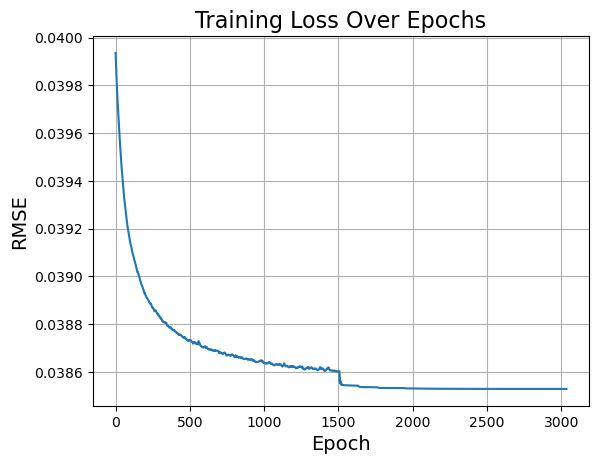

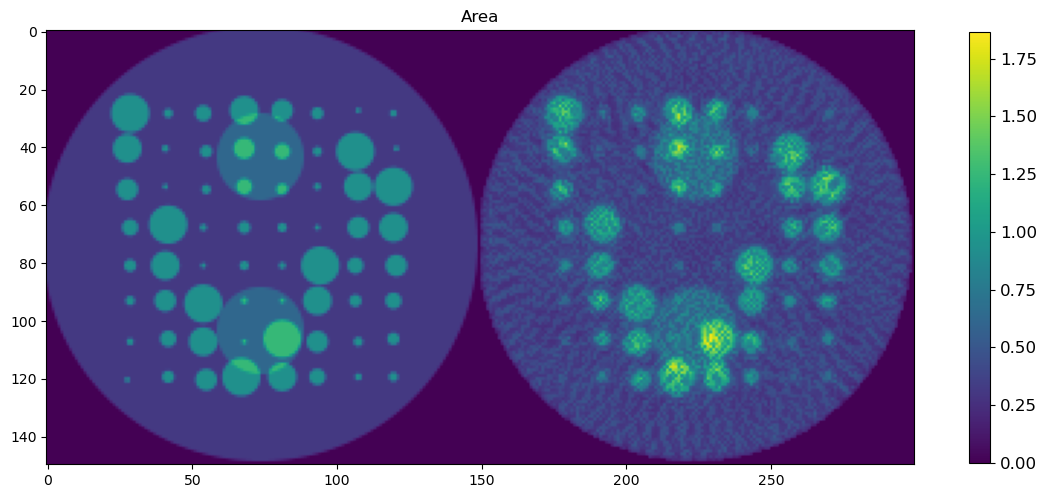

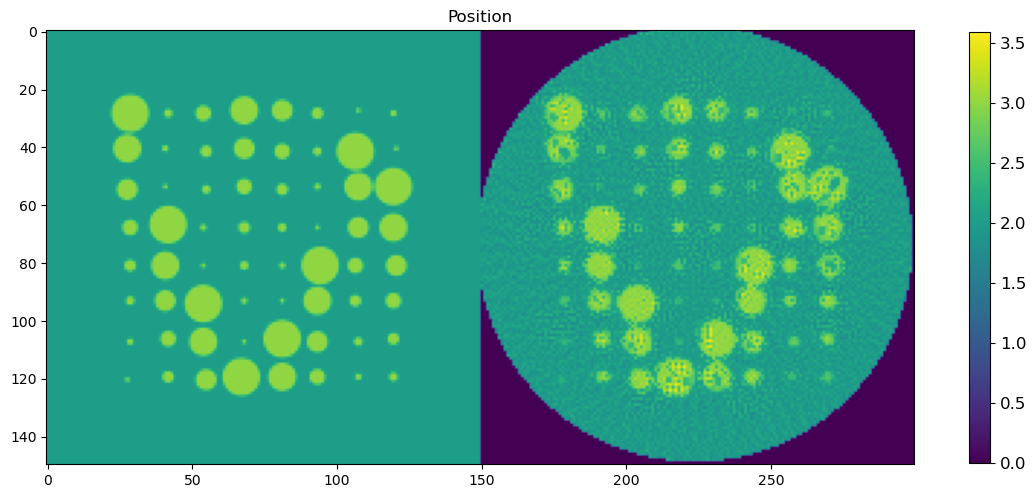

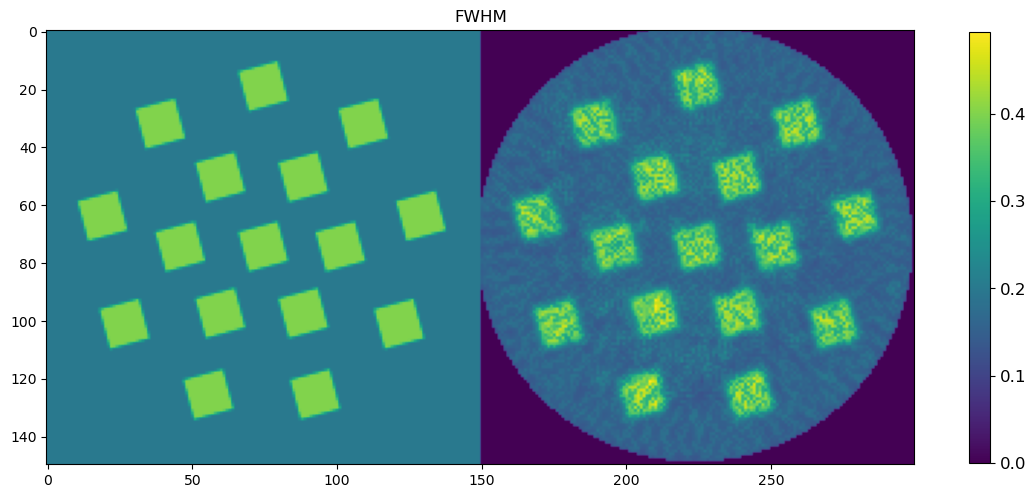

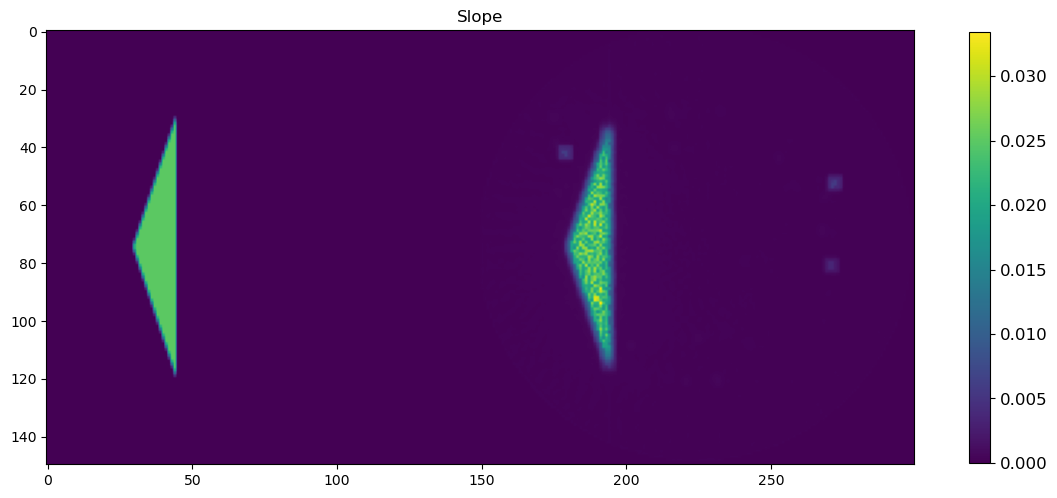

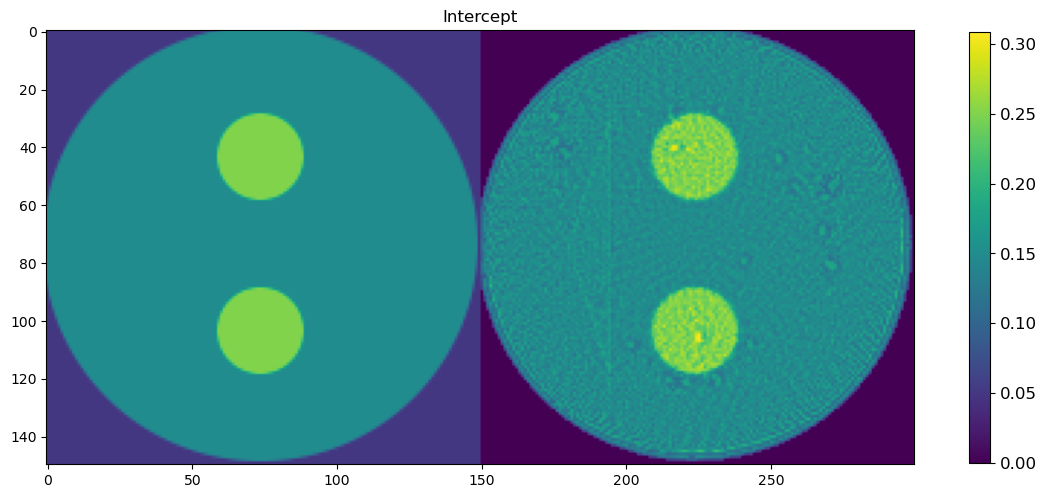

In [29]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Training Loss Over Epochs', fontsize=16)
plt.grid(True)
plt.show()

ims = model_prms_only(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)

prms_peak1_area_dlsr = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos_dlsr = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm_dlsr = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope_dlsr = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept_dlsr = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, prms_peak1_area_dlsr*msk), axis = 1)
posc = np.concatenate((peak_position, prms_peak1_pos_dlsr*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm, prms_peak1_fwhm_dlsr*msk), axis = 1)
slopec = np.concatenate((peak_slope, prms_slope_dlsr*msk), axis = 1)
interceptc = np.concatenate((peak_intercept, prms_intercept_dlsr*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
h = plt.imshow(areac)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
h = plt.imshow(posc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
h = plt.imshow(fwhmc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
h = plt.imshow(slopec)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
h = plt.imshow(interceptc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Intercept')
plt.show()

## 🤖 Define PeakFitCNN Model for Comparison with DLSR-prm

To benchmark the performance of DLSR, we now set up a second approach based on **self-supervised CNN-based peak fitting** using the PeakFitCNN model. This method is introduced and validated in a separate notebook.

### 🧠 PeakFitCNN Overview

- The CNN receives a **4× downsampled hyperspectral input volume**.
- It predicts full-resolution parameter maps for:
  - Peak area, position, FWHM
  - Background slope and intercept
- These maps are later used to reconstruct the full volume, which can be forward-projected and compared to the original sinogram.


### ⚙️ Model Configuration

- `nch_in`: number of diffraction channels (e.g., 20)
- `nch_out`: total number of output parameter maps (5 in this case)
- `nfilts`: number of filters, chosen here as equal to input channels for simplicity
- `upscale_factor = 4`: restores full resolution from the downsampled input
- `norm_type = 'layer'`: uses layer normalization for stability
- `activation = 'Sigmoid'`: ensures output values are in [0, 1] before denormalization

The total number of trainable parameters is printed and compared to the parameter count used in the DLSR approach.

### 🔻 Input Preparation

- The FBP reconstructed volume is reshaped into a 4D tensor compatible with PyTorch
- It is then **downsampled by a factor of 4** using bilinear interpolation

This downsampled input will be used to train PeakFitCNN in a self-supervised manner, mimicking limited-resolution experimental data. The upcoming training loop will mirror that used for DLSR but applied to this deep model.

In [6]:

model_cnn = PeakFitCNN(nch_in=volp.shape[2], nch_out=nch_out, nfilts=32,  upscale_factor = 4, norm_type='layer', 
              activation='Sigmoid', padding='same', npix = volp.shape[0]//4).to(device)


nch_in = volp.shape[2]
nfilts = volp.shape[2] # 2*total_params

# Calculate the total number of parameters
model_prms = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")

print('Number of filters:', nfilts)
print(nch_out)

print("Conventional number of parameters:", npix*npix*total_params)

print(volp.shape[0])

ylow = np.transpose(r, (2,1,0))
ylow = torch.tensor(ylow, dtype=torch.float32, device=device)
ylow = torch.reshape(ylow, (1, ylow.shape[0], ylow.shape[1], ylow.shape[2]))
ylow = torch.transpose(ylow, 3, 2)
downsampled = F.interpolate(ylow, scale_factor=1/4, mode='bilinear', align_corners=False)
print(downsampled.shape, yobs.shape, yobs.shape[2]/4)


Total number of parameters: 2073733
Number of filters: 20
5
Conventional number of parameters: 128000
160
torch.Size([1, 20, 40, 40]) torch.Size([1, 20, 160, 160]) 40.0


## 🔁 Train PeakFitCNN Using Self-Supervised Spectral Reconstruction

In this section, we train the `PeakFitCNN` model to reconstruct peak parameters directly from the **downsampled hyperspectral input**. The training follows the same **self-supervised loss formulation** as used in DLSR, where the forward projection of the predicted volume is matched against the observed sinogram.

### 🎯 Objective

Rather than optimizing parameter maps directly, as in DLSR, we now learn a **convolutional model** that:
- Takes as input a low-resolution hyperspectral volume
- Predicts full-resolution peak parameters
- Minimizes the sinogram error via a differentiable forward model

### 🧠 Training Setup

- `param_min` and `param_max`: define valid physical ranges for each parameter
- `prf = 0.2`: soft constraint (±20%) around the local average to stabilize output
- `optimizer`: Adam with learning rate `0.001`
- `scheduler`: Reduces learning rate when validation loss plateaus
- `loss`: RMSE between generated (`s_gen`) and true (`s`) sinograms

### 🔁 Training Loop

For each epoch:
1. Forward pass through `model_cnn(downsampled)`
2. Clamp and denormalize the predicted parameter maps
3. Reconstruct the full 3D volume from the predicted parameters
4. Apply forward projection to obtain a synthetic sinogram
5. Compute reconstruction error against the observed sinogram
6. Backpropagate and update model weights

The model is trained using **end-to-end self-supervision**, without any direct labels for peak parameters.

### 📈 Output

At the end of training, the notebook reports:
- Final values for MAE, MSE, and RMSE
- Number of epochs completed
- Total training time in seconds

This completes the CNN-based reconstruction, which we will next compare visually and quantitatively against the DLSR solution.

In [7]:
def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

epochs = 50000
patience = 50 #250
min_lr = 1E-5
learning_rate = 0.001
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    yc = model_cnn(downsampled)

    filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)
    lower_bound = filtered * (1 - prf)
    upper_bound = filtered * (1 + prf)
    yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

    y = torch.zeros((npix*npix, len(xv)), dtype=torch.float32).to(device)
    for i in range(num_peaks):
        
        area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
        position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
        fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

        area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
        position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
        fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

        area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
        position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
        fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
        
        y += gaussian(xv.unsqueeze(0), area, position, fwhm)

    slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
    intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

    slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
    intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

    slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
    intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

    y += slope * xv + intercept  
    y = torch.reshape(y, (1, npix, npix, nch))
    y = torch.transpose(y, 3, 1)
    y = torch.transpose(y, 3, 2)

    y = y * maskvol
    s_gen = forward_project_3D(y, angles, npix=yobs.shape[2], nch=yobs.shape[1], device='cuda')


    loss_mae =  MAE(s, s_gen)
    loss_mse = torch.mean((s - s_gen) ** 2)
    loss_rmse = torch.sqrt(torch.mean((s - s_gen) ** 2))
    
    loss = loss_rmse 
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
                
    logloss.append(loss.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch % int(patience*2) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

  0%|          | 3/50000 [00:01<4:10:40,  3.32it/s] 

MAE =  tensor(46.6050, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(3656.2676, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(60.4671, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  60.46708


  0%|          | 103/50000 [00:07<53:17, 15.60it/s] 

MAE =  tensor(2.9521, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(25.5371, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(5.0534, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  5.053422


  0%|          | 203/50000 [00:14<57:12, 14.51it/s]  

MAE =  tensor(1.9229, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(10.0414, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(3.1688, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  3.1688225


  1%|          | 303/50000 [00:21<51:19, 16.14it/s]  

MAE =  tensor(1.0203, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(2.8094, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.6761, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.6761379


  1%|          | 403/50000 [00:27<51:04, 16.19it/s]

MAE =  tensor(0.8660, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(1.7052, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.3058, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.3058243


  1%|          | 504/50000 [00:34<51:56, 15.88it/s]  

MAE =  tensor(0.7409, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(1.1888, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(1.0903, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  1.0903063


  1%|          | 602/50000 [00:40<58:22, 14.10it/s]  

MAE =  tensor(0.6013, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.8286, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.9103, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.9102559


  1%|▏         | 703/50000 [00:47<55:44, 14.74it/s]  

MAE =  tensor(0.5615, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.7155, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.8458, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.84584945


  2%|▏         | 803/50000 [00:53<50:28, 16.24it/s]

MAE =  tensor(0.4403, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.4648, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.6818, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.6817777


  2%|▏         | 903/50000 [01:00<51:19, 15.94it/s]  

MAE =  tensor(0.3954, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3598, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5998, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.59984404


  2%|▏         | 1003/50000 [01:06<53:30, 15.26it/s]

MAE =  tensor(0.3502, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2759, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5253, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.52525663


  2%|▏         | 1103/50000 [01:13<54:38, 14.92it/s]  

MAE =  tensor(0.3072, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.2178, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4667, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.46670815


  2%|▏         | 1203/50000 [01:20<51:17, 15.86it/s]

MAE =  tensor(0.2880, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1855, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4307, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.4307308


  3%|▎         | 1303/50000 [01:26<57:15, 14.17it/s]

MAE =  tensor(0.2662, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1623, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.4029, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.40287954


  3%|▎         | 1403/50000 [01:33<50:44, 15.96it/s]  

MAE =  tensor(0.2514, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1450, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3807, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.38072848


  3%|▎         | 1503/50000 [01:40<58:22, 13.85it/s]  

MAE =  tensor(0.2393, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1317, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3629, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.36286336


  3%|▎         | 1603/50000 [01:46<53:07, 15.19it/s]

MAE =  tensor(0.2275, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1186, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3443, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.34432393


  3%|▎         | 1703/50000 [01:53<52:15, 15.40it/s]

MAE =  tensor(0.2169, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.1073, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3276, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.32763898


  4%|▎         | 1803/50000 [02:00<1:00:40, 13.24it/s]

MAE =  tensor(0.2084, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3154, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.31541568


  4%|▍         | 1903/50000 [02:06<53:21, 15.02it/s]  

MAE =  tensor(0.2004, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0925, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.3041, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.30406603


  4%|▍         | 2003/50000 [02:13<55:45, 14.35it/s]

MAE =  tensor(0.1932, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0861, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2935, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.29350188


  4%|▍         | 2103/50000 [02:20<51:06, 15.62it/s]

MAE =  tensor(0.1918, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0795, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2819, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.28193727


  4%|▍         | 2203/50000 [02:26<58:38, 13.58it/s]  

MAE =  tensor(0.1866, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0736, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2713, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.27129462


  5%|▍         | 2303/50000 [02:33<54:02, 14.71it/s]  

MAE =  tensor(0.1722, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0692, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2630, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.26303163


  5%|▍         | 2403/50000 [02:40<52:57, 14.98it/s]

MAE =  tensor(0.1778, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0634, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2518, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.25180617


  5%|▌         | 2503/50000 [02:46<52:59, 14.94it/s]

MAE =  tensor(0.1757, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0610, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2469, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.24693361


  5%|▌         | 2603/50000 [02:53<52:12, 15.13it/s]

MAE =  tensor(0.1677, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0557, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2360, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.2360334


  5%|▌         | 2703/50000 [03:00<51:21, 15.35it/s]

MAE =  tensor(0.1599, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0526, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2294, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.22942519


  6%|▌         | 2803/50000 [03:06<52:05, 15.10it/s]

MAE =  tensor(0.1470, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.2198, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.21975166


  6%|▌         | 2903/50000 [03:13<51:40, 15.19it/s]

MAE =  tensor(0.0995, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0249, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1577, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15771154


  6%|▌         | 3003/50000 [03:19<52:00, 15.06it/s]

MAE =  tensor(0.0958, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1530, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.15299056


  6%|▌         | 3103/50000 [03:26<52:02, 15.02it/s]

MAE =  tensor(0.0925, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1483, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1483352


  6%|▋         | 3203/50000 [03:33<51:41, 15.09it/s]

MAE =  tensor(0.0891, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1435, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.14348443


  7%|▋         | 3303/50000 [03:39<51:48, 15.02it/s]

MAE =  tensor(0.0863, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0195, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1395, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1395224


  7%|▋         | 3403/50000 [03:46<50:02, 15.52it/s]

MAE =  tensor(0.0847, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0188, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1371, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13711835


  7%|▋         | 3503/50000 [03:52<51:08, 15.15it/s]

MAE =  tensor(0.0831, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0182, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1348, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13477498


  7%|▋         | 3603/50000 [03:59<51:27, 15.03it/s]

MAE =  tensor(0.0816, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0176, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1326, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.13255423


  7%|▋         | 3703/50000 [04:05<51:05, 15.10it/s]

MAE =  tensor(0.0800, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0170, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1304, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1304121


  8%|▊         | 3803/50000 [04:12<50:22, 15.28it/s]

MAE =  tensor(0.0785, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0165, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1283, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12829639


  8%|▊         | 3903/50000 [04:19<51:29, 14.92it/s]

MAE =  tensor(0.0769, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0159, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1260, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12604503


  8%|▊         | 4003/50000 [04:25<49:48, 15.39it/s]

MAE =  tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1243, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12429582


  8%|▊         | 4103/50000 [04:32<50:28, 15.15it/s]

MAE =  tensor(0.0763, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0154, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1240, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12403459


  8%|▊         | 4203/50000 [04:38<51:03, 14.95it/s]

MAE =  tensor(0.0763, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0152, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1235, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12348108


  9%|▊         | 4303/50000 [04:45<49:52, 15.27it/s]

MAE =  tensor(0.0761, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0151, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1228, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.122844435


  9%|▉         | 4403/50000 [04:52<49:23, 15.38it/s]

MAE =  tensor(0.0758, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0149, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1221, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.122112334


  9%|▉         | 4503/50000 [04:58<50:44, 14.94it/s]

MAE =  tensor(0.0751, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1215, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.12150663


  9%|▉         | 4603/50000 [05:05<52:30, 14.41it/s]

MAE =  tensor(0.0736, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0144, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1200, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11996308


  9%|▉         | 4703/50000 [05:11<50:07, 15.06it/s]

MAE =  tensor(0.0672, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0125, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1120, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11199609


 10%|▉         | 4803/50000 [05:18<49:22, 15.26it/s]

MAE =  tensor(0.0666, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1112, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11116163


 10%|▉         | 4903/50000 [05:24<49:41, 15.12it/s]

MAE =  tensor(0.0660, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1103, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.11031393


 10%|█         | 5003/50000 [05:31<48:45, 15.38it/s]

MAE =  tensor(0.0654, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0120, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1095, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1094545


 10%|█         | 5103/50000 [05:38<49:25, 15.14it/s]

MAE =  tensor(0.0648, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1086, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.108574525


 10%|█         | 5203/50000 [05:44<49:43, 15.01it/s]

MAE =  tensor(0.0641, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0116, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1077, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10767556


 11%|█         | 5303/50000 [05:51<49:06, 15.17it/s]

MAE =  tensor(0.0635, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1068, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.106757104


 11%|█         | 5403/50000 [05:57<48:35, 15.30it/s]

MAE =  tensor(0.0628, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1058, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.105827875


 11%|█         | 5503/50000 [06:04<49:07, 15.10it/s]

MAE =  tensor(0.0622, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0110, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1049, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10489856


 11%|█         | 5603/50000 [06:10<48:08, 15.37it/s]

MAE =  tensor(0.0616, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1042, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10415955


 11%|█▏        | 5703/50000 [06:17<48:40, 15.17it/s]

MAE =  tensor(0.0613, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1036, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10364417


 12%|█▏        | 5803/50000 [06:24<48:34, 15.17it/s]

MAE =  tensor(0.0609, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1032, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10316633


 12%|█▏        | 5903/50000 [06:30<49:49, 14.75it/s]

MAE =  tensor(0.0606, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0105, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1027, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10267295


 12%|█▏        | 6003/50000 [06:37<48:06, 15.24it/s]

MAE =  tensor(0.0602, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0104, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1022, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10215608


 12%|█▏        | 6103/50000 [06:43<48:54, 14.96it/s]

MAE =  tensor(0.0598, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1016, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10162193


 12%|█▏        | 6203/50000 [06:50<48:58, 14.90it/s]

MAE =  tensor(0.0595, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1011, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.10107458


 13%|█▎        | 6303/50000 [06:57<48:20, 15.06it/s]

MAE =  tensor(0.0591, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.1005, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.1005139


 13%|█▎        | 6403/50000 [07:03<48:47, 14.89it/s]

MAE =  tensor(0.0587, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0100, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0999, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09994288


 13%|█▎        | 6503/50000 [07:10<48:22, 14.98it/s]

MAE =  tensor(0.0583, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0994, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09936028


 13%|█▎        | 6603/50000 [07:16<47:40, 15.17it/s]

MAE =  tensor(0.0579, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0098, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0988, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.098766536


 13%|█▎        | 6703/50000 [07:23<48:20, 14.93it/s]

MAE =  tensor(0.0575, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0097, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0983, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09827916


 14%|█▎        | 6803/50000 [07:30<47:58, 15.01it/s]

MAE =  tensor(0.0571, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0095, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0977, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09765408


 14%|█▍        | 6903/50000 [07:36<47:17, 15.19it/s]

MAE =  tensor(0.0567, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0971, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.097112454


 14%|█▍        | 7003/50000 [07:43<47:21, 15.13it/s]

MAE =  tensor(0.0568, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0970, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09695555


 14%|█▍        | 7103/50000 [07:49<46:58, 15.22it/s]

MAE =  tensor(0.0561, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0961, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09606431


 14%|█▍        | 7203/50000 [07:56<47:42, 14.95it/s]

MAE =  tensor(0.0557, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0956, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09560055


 15%|█▍        | 7303/50000 [08:03<47:13, 15.07it/s]

MAE =  tensor(0.0568, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0093, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0964, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0964261


 15%|█▍        | 7403/50000 [08:09<46:48, 15.17it/s]

MAE =  tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0944, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09444526


 15%|█▌        | 7503/50000 [08:16<46:47, 15.14it/s]

MAE =  tensor(0.0564, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0960, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09598175


 15%|█▌        | 7603/50000 [08:22<47:23, 14.91it/s]

MAE =  tensor(0.0547, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0939, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.093903266


 15%|█▌        | 7703/50000 [08:29<46:39, 15.11it/s]

MAE =  tensor(0.0538, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0930, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09299785


 16%|█▌        | 7803/50000 [08:36<46:19, 15.18it/s]

MAE =  tensor(0.0536, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0928, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.092753254


 16%|█▌        | 7903/50000 [08:42<46:44, 15.01it/s]

MAE =  tensor(0.0534, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0925, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09250225


 16%|█▌        | 8003/50000 [08:49<46:35, 15.02it/s]

MAE =  tensor(0.0532, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0922, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09224357


 16%|█▌        | 8103/50000 [08:56<46:36, 14.98it/s]

MAE =  tensor(0.0531, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0920, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.091975816


 16%|█▋        | 8203/50000 [09:02<46:49, 14.88it/s]

MAE =  tensor(0.0529, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0917, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09169881


 17%|█▋        | 8303/50000 [09:09<46:02, 15.09it/s]

MAE =  tensor(0.0527, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0914, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09141195


 17%|█▋        | 8403/50000 [09:15<45:15, 15.32it/s]

MAE =  tensor(0.0524, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0911, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.09111499


 17%|█▋        | 8503/50000 [09:22<45:44, 15.12it/s]

MAE =  tensor(0.0522, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0908, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.090805255


 17%|█▋        | 8603/50000 [09:28<45:25, 15.19it/s]

MAE =  tensor(0.0520, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0905, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.090482876


 17%|█▋        | 8703/50000 [09:35<45:53, 15.00it/s]

MAE =  tensor(0.0518, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0902, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.090152174


 18%|█▊        | 8803/50000 [09:42<44:46, 15.33it/s]

MAE =  tensor(0.0515, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0898, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0898126


 18%|█▊        | 8903/50000 [09:48<46:05, 14.86it/s]

MAE =  tensor(0.0515, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0080, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0896, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08964033


 18%|█▊        | 9003/50000 [09:55<45:32, 15.00it/s]

MAE =  tensor(0.0517, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0898, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08976318


 18%|█▊        | 9103/50000 [10:01<45:37, 14.94it/s]

MAE =  tensor(0.0508, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0888, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08879002


 18%|█▊        | 9203/50000 [10:08<44:55, 15.14it/s]

MAE =  tensor(0.0507, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0885, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08854824


 19%|█▊        | 9303/50000 [10:15<44:45, 15.15it/s]

MAE =  tensor(0.0504, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0882, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0881893


 19%|█▉        | 9403/50000 [10:21<44:42, 15.14it/s]

MAE =  tensor(0.0510, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0886, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08860876


 19%|█▉        | 9503/50000 [10:28<44:26, 15.19it/s]

MAE =  tensor(0.0510, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0885, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.088547885


 19%|█▉        | 9603/50000 [10:34<44:29, 15.13it/s]

MAE =  tensor(0.0502, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0876, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.087595396


 19%|█▉        | 9703/50000 [10:41<44:27, 15.11it/s]

MAE =  tensor(0.0496, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0870, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0869688


 20%|█▉        | 9803/50000 [10:47<43:54, 15.26it/s]

MAE =  tensor(0.0499, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0871, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08713582


 20%|█▉        | 9903/50000 [10:54<44:18, 15.08it/s]

MAE =  tensor(0.0491, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0075, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0863, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08631434


 20%|██        | 10003/50000 [11:01<43:45, 15.23it/s]

MAE =  tensor(0.0492, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0863, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.086270094


 20%|██        | 10103/50000 [11:07<44:25, 14.97it/s]

MAE =  tensor(0.0489, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0860, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08597829


 20%|██        | 10203/50000 [11:14<43:44, 15.17it/s]

MAE =  tensor(0.0485, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0855, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08554411


 21%|██        | 10303/50000 [11:20<43:26, 15.23it/s]

MAE =  tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0853, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08527533


 21%|██        | 10403/50000 [11:27<43:28, 15.18it/s]

MAE =  tensor(0.0482, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0851, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08505068


 21%|██        | 10503/50000 [11:33<43:14, 15.23it/s]

MAE =  tensor(0.0481, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0849, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.084857196


 21%|██        | 10603/50000 [11:40<42:38, 15.40it/s]

MAE =  tensor(0.0477, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0844, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.084408954


 21%|██▏       | 10703/50000 [11:47<43:25, 15.08it/s]

MAE =  tensor(0.0478, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0844, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08440735


 22%|██▏       | 10803/50000 [11:53<42:48, 15.26it/s]

MAE =  tensor(0.0475, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0071, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0841, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.084063314


 22%|██▏       | 10903/50000 [12:00<41:59, 15.52it/s]

MAE =  tensor(0.0471, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0836, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.083618425


 22%|██▏       | 11003/50000 [12:06<42:58, 15.13it/s]

MAE =  tensor(0.0471, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0836, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0835722


 22%|██▏       | 11103/50000 [12:13<42:46, 15.16it/s]

MAE =  tensor(0.0471, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0070, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0835, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08345566


 22%|██▏       | 11203/50000 [12:20<42:15, 15.30it/s]

MAE =  tensor(0.0466, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0829, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08290402


 23%|██▎       | 11303/50000 [12:26<42:57, 15.01it/s]

MAE =  tensor(0.0464, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0826, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08259993


 23%|██▎       | 11403/50000 [12:33<43:22, 14.83it/s]

MAE =  tensor(0.0463, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0825, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.082474746


 23%|██▎       | 11503/50000 [12:39<42:27, 15.11it/s]

MAE =  tensor(0.0462, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0823, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08234647


 23%|██▎       | 11603/50000 [12:46<43:07, 14.84it/s]

MAE =  tensor(0.0461, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0822, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08221444


 23%|██▎       | 11703/50000 [12:53<42:44, 14.93it/s]

MAE =  tensor(0.0460, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0821, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.082078554


 24%|██▎       | 11803/50000 [12:59<41:44, 15.25it/s]

MAE =  tensor(0.0459, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0819, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.081938624


 24%|██▍       | 11903/50000 [13:06<42:25, 14.97it/s]

MAE =  tensor(0.0458, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0818, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08179414


 24%|██▍       | 12003/50000 [13:12<41:44, 15.17it/s]

MAE =  tensor(0.0457, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0067, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0816, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08164496


 24%|██▍       | 12103/50000 [13:19<42:20, 14.92it/s]

MAE =  tensor(0.0455, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0815, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08149159


 24%|██▍       | 12203/50000 [13:26<41:24, 15.22it/s]

MAE =  tensor(0.0454, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0813, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.081333764


 25%|██▍       | 12303/50000 [13:32<42:10, 14.90it/s]

MAE =  tensor(0.0453, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0812, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.081170954


 25%|██▍       | 12403/50000 [13:39<41:29, 15.10it/s]

MAE =  tensor(0.0452, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0066, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0810, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08100279


 25%|██▌       | 12503/50000 [13:45<41:34, 15.03it/s]

MAE =  tensor(0.0451, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0808, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.080831915


 25%|██▌       | 12603/50000 [13:52<40:17, 15.47it/s]

MAE =  tensor(0.0449, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0807, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08066107


 25%|██▌       | 12703/50000 [13:59<40:47, 15.24it/s]

MAE =  tensor(0.0448, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0805, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08053232


 26%|██▌       | 12803/50000 [14:05<40:27, 15.33it/s]

MAE =  tensor(0.0447, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0803, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08032364


 26%|██▌       | 12903/50000 [14:12<41:38, 14.85it/s]

MAE =  tensor(0.0446, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0802, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08015923


 26%|██▌       | 13003/50000 [14:18<41:04, 15.01it/s]

MAE =  tensor(0.0447, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0802, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.08020584


 26%|██▌       | 13103/50000 [14:25<40:18, 15.26it/s]

MAE =  tensor(0.0443, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0799, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.079852805


 26%|██▋       | 13203/50000 [14:32<40:11, 15.26it/s]

MAE =  tensor(0.0443, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0797, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07973799


 27%|██▋       | 13303/50000 [14:38<40:47, 14.99it/s]

MAE =  tensor(0.0441, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0795, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07951566


 27%|██▋       | 13403/50000 [14:45<39:25, 15.47it/s]

MAE =  tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0794, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07936097


 27%|██▋       | 13503/50000 [14:51<39:53, 15.25it/s]

MAE =  tensor(0.0439, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0793, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07925434


 27%|██▋       | 13603/50000 [14:58<40:46, 14.88it/s]

MAE =  tensor(0.0438, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0791, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07908578


 27%|██▋       | 13703/50000 [15:04<40:10, 15.06it/s]

MAE =  tensor(0.0436, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0789, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07890034


 28%|██▊       | 13803/50000 [15:11<39:22, 15.32it/s]

MAE =  tensor(0.0435, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0788, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07878014


 28%|██▊       | 13903/50000 [15:18<38:44, 15.53it/s]

MAE =  tensor(0.0434, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0786, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07861511


 28%|██▊       | 14003/50000 [15:24<40:01, 14.99it/s]

MAE =  tensor(0.0433, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0785, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07847818


 28%|██▊       | 14103/50000 [15:31<40:12, 14.88it/s]

MAE =  tensor(0.0432, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0783, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07833284


 28%|██▊       | 14203/50000 [15:37<39:18, 15.18it/s]

MAE =  tensor(0.0431, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0782, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07817269


 29%|██▊       | 14303/50000 [15:44<39:36, 15.02it/s]

MAE =  tensor(0.0430, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0780, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07801882


 29%|██▉       | 14403/50000 [15:50<38:43, 15.32it/s]

MAE =  tensor(0.0432, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0781, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.078149505


 29%|██▉       | 14503/50000 [15:57<39:53, 14.83it/s]

MAE =  tensor(0.0428, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0778, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07776408


 29%|██▉       | 14603/50000 [16:04<39:29, 14.94it/s]

MAE =  tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0776, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07760865


 29%|██▉       | 14703/50000 [16:10<39:13, 15.00it/s]

MAE =  tensor(0.0426, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0775, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07752972


 30%|██▉       | 14803/50000 [16:17<38:56, 15.06it/s]

MAE =  tensor(0.0426, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0774, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.077398516


 30%|██▉       | 14903/50000 [16:23<38:16, 15.28it/s]

MAE =  tensor(0.0424, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0772, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.077190705


 30%|███       | 15003/50000 [16:30<38:40, 15.08it/s]

MAE =  tensor(0.0423, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0771, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07708205


 30%|███       | 15103/50000 [16:37<38:25, 15.14it/s]

MAE =  tensor(0.0424, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0771, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.077128634


 30%|███       | 15203/50000 [16:43<37:55, 15.29it/s]

MAE =  tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0768, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.076832056


 31%|███       | 15303/50000 [16:50<38:24, 15.05it/s]

MAE =  tensor(0.0420, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0766, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.076641575


 31%|███       | 15403/50000 [16:56<37:43, 15.29it/s]

MAE =  tensor(0.0419, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0765, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07650595


 31%|███       | 15503/50000 [17:03<38:10, 15.06it/s]

MAE =  tensor(0.0418, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0764, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.076368436


 31%|███       | 15603/50000 [17:09<37:30, 15.28it/s]

MAE =  tensor(0.0419, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0764, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07643449


 31%|███▏      | 15703/50000 [17:16<37:45, 15.14it/s]

MAE =  tensor(0.0416, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0762, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07615167


 32%|███▏      | 15803/50000 [17:23<37:30, 15.19it/s]

MAE =  tensor(0.0415, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0760, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.075979985


 32%|███▏      | 15903/50000 [17:29<36:49, 15.43it/s]

MAE =  tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0058, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0759, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07586955


 32%|███▏      | 16003/50000 [17:36<36:05, 15.70it/s]

MAE =  tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0758, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.075787455


 32%|███▏      | 16103/50000 [17:42<36:49, 15.34it/s]

MAE =  tensor(0.0412, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0756, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07561175


 32%|███▏      | 16203/50000 [17:49<37:08, 15.17it/s]

MAE =  tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0757, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07568177


 33%|███▎      | 16303/50000 [17:55<37:03, 15.15it/s]

MAE =  tensor(0.0411, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0754, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07542091


 33%|███▎      | 16403/50000 [18:02<36:41, 15.26it/s]

MAE =  tensor(0.0410, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0057, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0753, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07528138


 33%|███▎      | 16503/50000 [18:09<37:32, 14.87it/s]

MAE =  tensor(0.0409, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0752, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0751509


 33%|███▎      | 16603/50000 [18:15<37:00, 15.04it/s]

MAE =  tensor(0.0408, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0750, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07502316


 33%|███▎      | 16703/50000 [18:22<36:23, 15.25it/s]

MAE =  tensor(0.0407, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0749, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0749003


 34%|███▎      | 16803/50000 [18:28<35:57, 15.39it/s]

MAE =  tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0748, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07478674


 34%|███▍      | 16903/50000 [18:35<37:02, 14.89it/s]

MAE =  tensor(0.0406, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0747, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07467206


 34%|███▍      | 17003/50000 [18:42<36:45, 14.96it/s]

MAE =  tensor(0.0405, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0746, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.074558996


 34%|███▍      | 17103/50000 [18:48<35:55, 15.26it/s]

MAE =  tensor(0.0405, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0746, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.074567854


 34%|███▍      | 17203/50000 [18:55<36:46, 14.86it/s]

MAE =  tensor(0.0404, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0744, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07435829


 35%|███▍      | 17303/50000 [19:02<36:16, 15.02it/s]

MAE =  tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0742, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0742298


 35%|███▍      | 17403/50000 [19:08<36:20, 14.95it/s]

MAE =  tensor(0.0402, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0741, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07411838


 35%|███▌      | 17503/50000 [19:15<35:55, 15.08it/s]

MAE =  tensor(0.0401, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0740, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07401935


 35%|███▌      | 17603/50000 [19:21<35:50, 15.06it/s]

MAE =  tensor(0.0400, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0055, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0739, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07390735


 35%|███▌      | 17703/50000 [19:28<35:59, 14.96it/s]

MAE =  tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0738, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07380228


 36%|███▌      | 17803/50000 [19:35<35:15, 15.22it/s]

MAE =  tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0738, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07375293


 36%|███▌      | 17903/50000 [19:41<35:50, 14.93it/s]

MAE =  tensor(0.0398, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0736, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07358873


 36%|███▌      | 18003/50000 [19:48<35:17, 15.11it/s]

MAE =  tensor(0.0397, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0735, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.073486924


 36%|███▌      | 18103/50000 [19:54<35:08, 15.13it/s]

MAE =  tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0736, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.073602006


 36%|███▋      | 18203/50000 [20:01<34:43, 15.26it/s]

MAE =  tensor(0.0396, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0733, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.07331118


 37%|███▋      | 18303/50000 [20:08<35:02, 15.07it/s]

MAE =  tensor(0.0396, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0733, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0733107


 37%|███▋      | 18360/50000 [20:11<34:48, 15.15it/s]

Minimum learning rate reached, stopping the optimization
18360
18360 tensor(0.0396, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0733, device='cuda:0', grad_fn=<SqrtBackward0>) 0.07328672
1211.8666760921478


## 🧪 Visual Comparison of DLSR-PeakFitCNN vs. DLSR-prm vs. Ground Truth

After completing training for the PeakFitCNN-based reconstruction, we extract the final parameter maps and visually compare them side-by-side with:
- The **ground truth maps** from the synthetic phantom
- The maps reconstructed using **DLSR-prm**
- The maps reconstructed using **DLSR-PeakFitCNN**

### 📉 Loss Curve

We begin by plotting the RMSE loss (`logloss`) from the CNN training to verify convergence and performance.

### 🗺️ Extract CNN Parameter Maps

We:
- Perform a final forward pass through the trained `model_cnn`
- Apply local smoothing and soft clamping
- Denormalize all five peak parameters to physical units

Cropped padding is removed using `ofs`, and a mask (`msk`) is applied to ignore low-signal/background areas in the comparison.

### 🧭 Visual Layout

For each parameter (Area, Position, FWHM, Slope, Intercept), we concatenate the masked maps:
- **Left**: Ground truth
- **Middle**: Parameter-map-only
- **Right**: PeakFitCNN

This layout allows qualitative assessment of:
- **Accuracy**: closeness to ground truth
- **Smoothness**: spatial continuity
- **Noise suppression**: denoising capability under angular undersampling

### 🖼️ Display Results

All parameter maps are shown using the `'jet'` colormap for enhanced contrast. The results suggest that both DLSR and CNN-based approaches recover the key spatial patterns well, with CNN exhibiting better smoothness in some cases — particularly under undersampled conditions.

In the next step, a quantitative comparison (e.g. RMSE or SSIM) can further validate these observations.

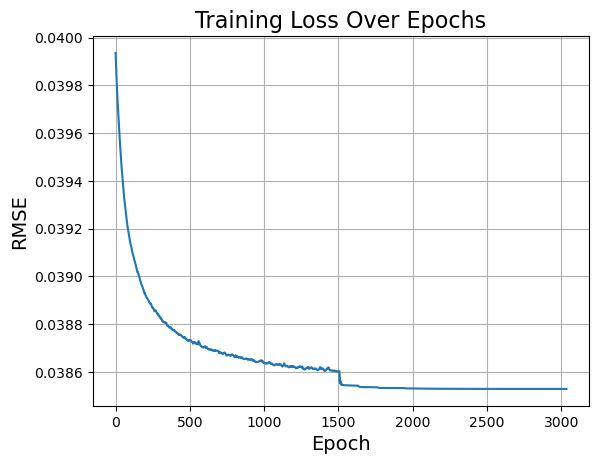

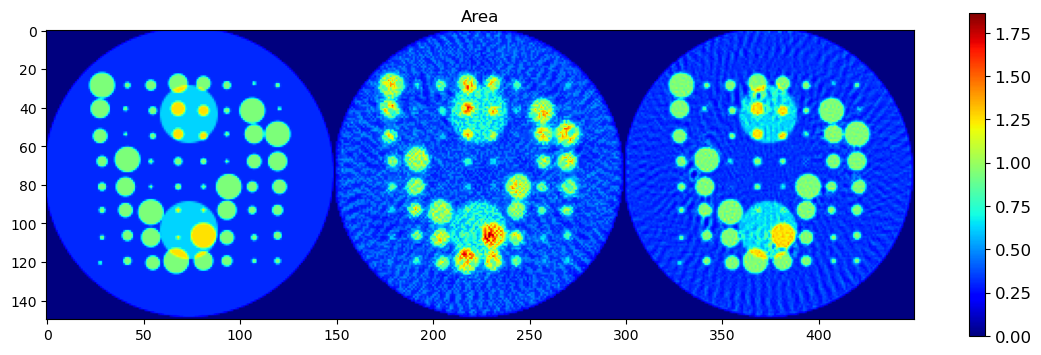

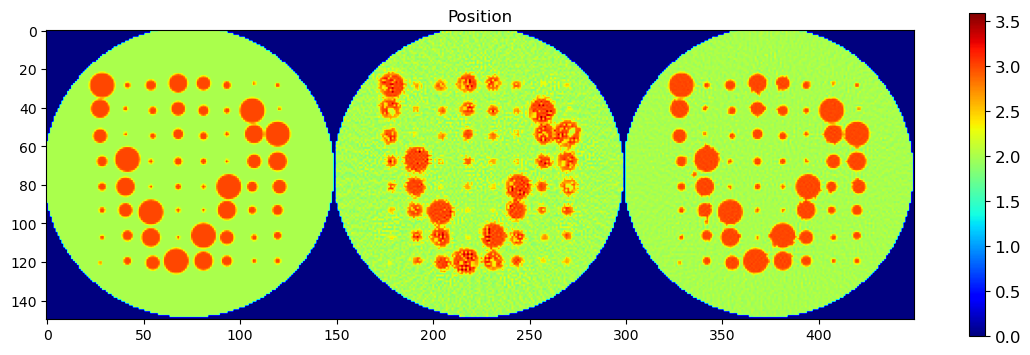

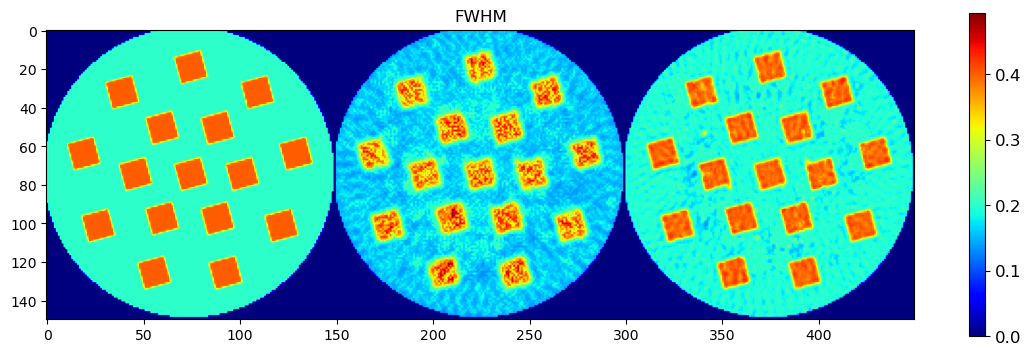

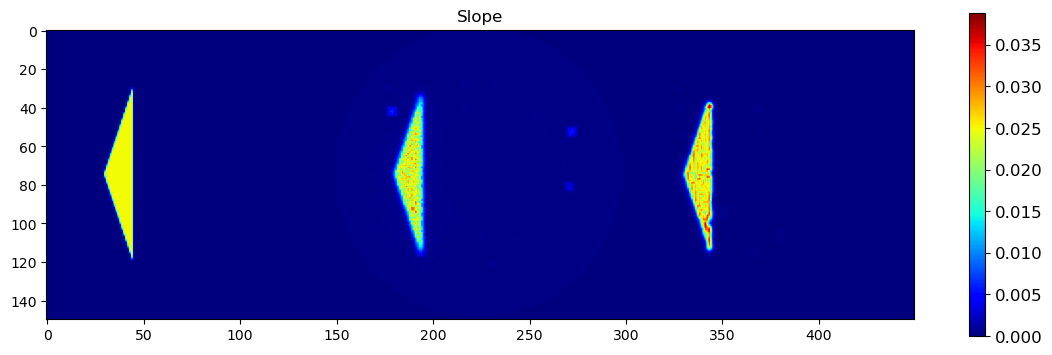

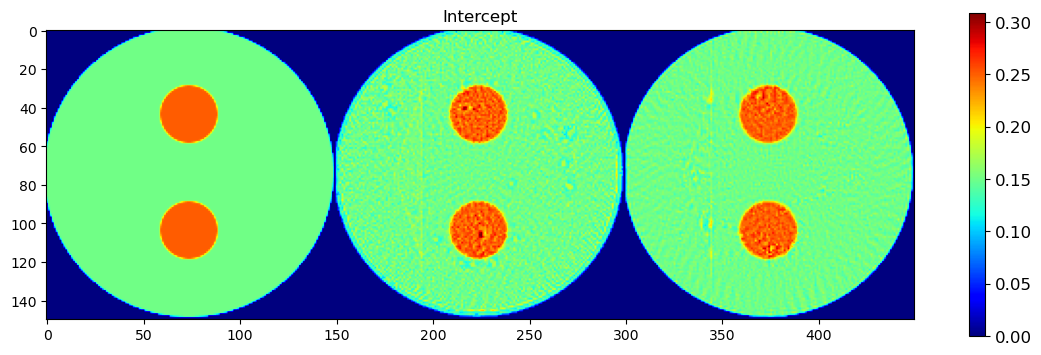

In [38]:
%matplotlib inline

plt.figure(1);plt.clf()
plt.plot(logloss[100:])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('Training Loss Over Epochs', fontsize=16)
plt.grid(True)
plt.show()

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area*msk,prms_peak1_area_dlsr*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, prms_peak1_pos_dlsr*msk, cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, prms_peak1_fwhm_dlsr*msk, cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, prms_slope_dlsr*msk, cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, prms_intercept_dlsr*msk, cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
h = plt.imshow(areac, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.3)
cbar.ax.tick_params(labelsize=12)
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
h = plt.imshow(posc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.3)
cbar.ax.tick_params(labelsize=12)
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
h = plt.imshow(fwhmc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.3)
cbar.ax.tick_params(labelsize=12)
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
h = plt.imshow(slopec, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.3)
cbar.ax.tick_params(labelsize=12)
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
h = plt.imshow(interceptc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.3)
cbar.ax.tick_params(labelsize=12)
plt.title('Intercept')
plt.show()


## 🔍 Patch-Based Sampling on FBP-Reconstructed Volume

This section defines a patch sampling strategy for the **FBP + peak fitting** pipeline, enabling efficient evaluation or training using the reconstructed volume `r` as input.

### 🎯 Purpose

Patch-based sampling allows us to:
- Randomly probe local regions of the FBP volume
- Enable fair comparison with CNN and DLSR methods that were also trained on patches
- Optionally fit peaks or extract local statistics from each patch

### 🧱 Workflow

1. **Volume and Mask Padding**:
   - Padding is added around the spatial edges of both the FBP volume (`r`) and the binary mask.
   - This ensures patches sampled near the boundary are still valid.

2. **Mask Generation**:
   - A binary mask is generated by summing the FBP volume along the spectral axis.
   - Voxels with non-zero values are marked as valid for sampling.

3. **Patch Index Filtering**:
   - Using `filter_patch_indices()`, we identify valid patch locations that overlap with signal.
   - The number of patches per iteration and total number of required iterations to probe the entire image are computed.

4. **Coverage Diagnostic**:
   - A counter tracks how often each voxel is sampled.
   - This is visualized to ensure spatially uniform coverage across the volume.

### 📈 Output

The code prints:
- Volume and mask shapes after padding
- Estimated patch coverage per epoch
- Number of required iterations to probe the full image
- Number of valid patches available
- Visualization of the sampling density

This setup prepares the FBP data for further analysis — for example, comparing peak fitting accuracy or robustness under noisy or undersampled conditions.

(224, 224, 20) (160, 160, 20) (224, 224)


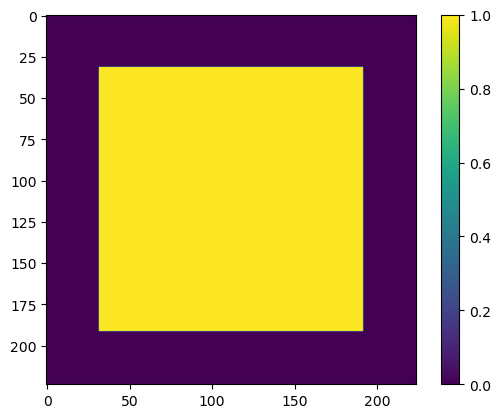

Percentage of pixels probed during one epoch: 64.0
Number of iterations required to probe full image: 2
The number of patches is  25
The number of iterations (batches) required to probe the whole image is  1
tensor(1.)


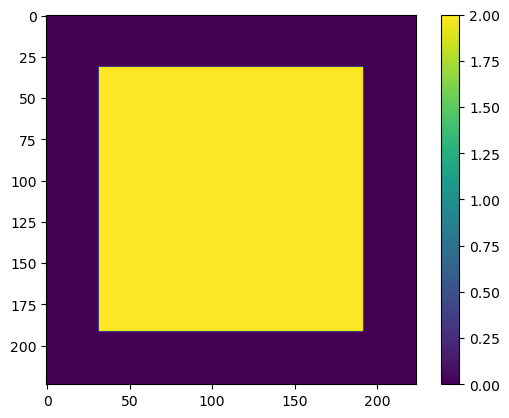

(224, 224, 20) (160, 160, 20) (224, 224)


In [9]:
%matplotlib inline

num_iterations = 100
distribution_type = 'uniform'
std_dev = int(r.shape[0] / 1)
device = 'cuda'
patch_size = 32
num_patches = 16
num_patches_total = 16

mask = np.copy(np.sum(r,axis=2))
mask[mask>0] = 1
mask = np.concatenate((np.zeros((patch_size, mask.shape[1]), dtype='float32'), mask, np.zeros((patch_size, mask.shape[1]), dtype='float32')), axis = 0)
mask = np.concatenate((np.zeros((mask.shape[0], patch_size), dtype='float32'), mask, np.zeros((mask.shape[0], patch_size), dtype='float32')), axis = 1)

volp = np.copy(r)
volp = np.concatenate((np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32'), volp, np.zeros((patch_size, volp.shape[1], volp.shape[2]), dtype='float32')), axis = 0)
volp = np.concatenate((np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32'), volp, np.zeros((volp.shape[0], patch_size, volp.shape[2]), dtype='float32')), axis = 1)
rows, cols = volp.shape[0], volp.shape[1]  # Size of the matrix
print(volp.shape, r.shape, mask.shape)

plt.figure(1);plt.clf()
plt.imshow(mask)
plt.colorbar()
plt.show()

npix = np.sum(mask)
pcr_probed = 100* (patch_size*patch_size*num_patches)/npix
print(f"Percentage of pixels probed during one epoch: {pcr_probed}")
niters_required = int(np.ceil(100/pcr_probed))
print(f"Number of iterations required to probe full image: {niters_required}")

mask_t = torch.tensor(mask, dtype=torch.bool, device=device)

indices = filter_patch_indices(torch.tensor(mask), patch_size)
print('The number of patches is ', len(indices))
print('The number of iterations (batches) required to probe the whole image is ', int(len(indices)/num_patches) )


counter = initialize_counter(rows, cols)
patch_dimensions = (patch_size, patch_size)
update_counter(counter, indices, patch_dimensions)

print(counter.max())

counter = counter.numpy()

plt.figure(2);plt.clf()
# plt.imshow(counter * mask )
plt.imshow(counter + mask)
# plt.clim(0,1)
plt.colorbar()
plt.show()

print(volp.shape, vol.shape, mask.shape)


## 🔁 Train Parameter Maps on FBP-Reconstructed Volume (FBP + Peak Fitting)

This section trains parameter maps directly on the **FBP-reconstructed volume** using the same architecture (`PrmCNN2D`) and training strategy as in the DLSR case. The difference here is that the input data is a **reconstructed volume** (`r`) rather than raw sinogram data.

### 🎯 Purpose

This pipeline simulates the conventional XRD-CT workflow:
1. Reconstruct the 3D volume using FBP
2. Fit diffraction patterns voxel-by-voxel to extract physical parameters (area, position, FWHM, etc.)

By training `PrmCNN2D` to minimize reconstruction error, we obtain spatially smooth parameter maps from the FBP output.

### ⚙️ Training Configuration

- Input: `im_static`, a single-channel static image computed from the FBP volume
- Patch-based training ensures efficiency and robustness
- `prf = 0.2`: enforces stability by soft-clamping parameter predictions
- Training loss is RMSE between the observed FBP voxel spectra and those reconstructed from the fitted parameters

### 🔁 Training Loop

Each epoch consists of:
1. Predicting parameter maps (`yc`)
2. Clamping predictions and extracting patches
3. Constructing synthetic spectra from peak + background parameters
4. Comparing synthetic spectra with the ground truth patches (`yobs`)
5. Computing RMSE and updating the model

### 📈 Output

The model prints:
- MAE, MSE, RMSE at intermediate epochs
- Accumulated loss over iterations
- Total training time and number of completed epochs

This completes the **FBP + peak fitting pipeline**, enabling direct comparison with DLSR and CNN-based methods in the final evaluation section.

In [10]:

npix_x = volp.shape[0]
npix_y = volp.shape[1]
xv = torch.tensor(x, dtype=torch.float32, device='cuda')

### Single peak
peak_definitions = [(1, 1.0, 4.0)]

num_peaks = len(peak_definitions)
num_params_per_peak = 3  # Area, Position, FWHM
background_params = 2  # Slope, Intercept
total_params = num_peaks * num_params_per_peak + background_params

npix = volp.shape[0]
nch_in = total_params
nch_out = total_params
nfilts = 2*total_params # 2*total_params is pretty good when using norm layer
norm_type='layer'
activation='Sigmoid'
downsampling = 8
device = 'cuda'

model = PrmCNN2D(npix, nch_in=nch_in, nch_out=nch_out, nfilts=nfilts, nlayers=1, norm_type='None', prms_layer=True, cnn_layer=False, tensor_vals = 'zeros').to(device)
model_prms = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {model_prms}")
print("Conventional number of parameters:", npix*npix*total_params)

def gaussian(x, area, position, fwhm):
    """Gaussian peak shape."""
    return area * torch.exp(-(x - position)**2 / (2 * fwhm**2))
    
MAE = torch.nn.L1Loss()

### Single peak ###
param_min = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Position': torch.tensor([peak[1] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.1,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device),
    'Slope': torch.zeros(1, dtype=torch.float32).to(device),
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device),
}
param_max = {
    'Area': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 2,
    'Position': torch.tensor([peak[2] for peak in peak_definitions], dtype=torch.float32).to(device),
    'FWHM': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 0.5,
    'Fraction': torch.zeros(num_peaks, dtype=torch.float32).to(device) + 1,
    'Slope': torch.zeros(1, dtype=torch.float32).to(device) + 0.2,
    'Intercept': torch.zeros(1, dtype=torch.float32).to(device) + 0.5,
}    

nch = volp.shape[2]
learning_rate = 0.001
epochs = 10000
min_lr = 1E-5

im_static = np.sum(volp, axis=2)
im_static = im_static/np.max(im_static)
im_static = np.reshape(im_static, (1, 1, volp.shape[1], volp.shape[1]))
im_static = torch.tensor(im_static, dtype=torch.float32, device=device)

yobs = np.transpose(volp, (2,1,0))
yobs = torch.tensor(yobs, dtype=torch.float32, device=device)
yobs = torch.reshape(yobs, (1, yobs.shape[0], yobs.shape[1], yobs.shape[2]))
yobs = torch.transpose(yobs, 3, 2)

epochs = 50000
patience = 100 #250
min_lr = 1E-5
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
prf = 0.2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, min_lr=min_lr)

num_patches = 16
new_indices = np.array(indices)
total_indices = len(indices)
num_batches = (total_indices + num_patches - 1) // num_patches
print(num_batches)

start = time.time()
logloss = []

for epoch in tqdm(range(epochs)):

    loss_acc = 0
    
    for batch_index in range(num_batches):
        start_index = batch_index * num_patches
        end_index = min(start_index + num_patches, total_indices)
        batch_indices = new_indices[start_index:end_index]

        yc = model(im_static)
        filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(yc)

        lower_bound = filtered * (1 - prf)
        upper_bound = filtered * (1 + prf)

        yc = torch.clamp(yc, min=lower_bound, max=upper_bound)

        yc = calc_patches_indices(batch_indices, yc, patch_size, use_middle=False)

        y = torch.zeros((patch_size*patch_size*len(batch_indices), len(xv)), dtype=torch.float32).to(device)
        
        for i in range(num_peaks):
            area = denormalize(yc[:, i * 3, :, :], 'Area', param_min, param_max, i)
            position = denormalize(yc[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)
            fwhm = denormalize(yc[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)

            area = torch.transpose(torch.reshape(area, (area.shape[0], area.shape[1]*area.shape[2])), 1, 0)
            position = torch.transpose(torch.reshape(position, (position.shape[0], position.shape[1]*position.shape[2])), 1, 0)
            fwhm = torch.transpose(torch.reshape(fwhm, (fwhm.shape[0], fwhm.shape[1]*fwhm.shape[2])), 1, 0)

            area = torch.reshape(area, (area.shape[0]*area.shape[1], 1))
            position = torch.reshape(position, (area.shape[0]*area.shape[1], 1))
            fwhm = torch.reshape(fwhm, (area.shape[0]*area.shape[1], 1))
            
            y += gaussian(xv.unsqueeze(0), area, position, fwhm)
        
        slope = denormalize(yc[:, -2, :, :], 'Slope', param_min, param_max, )
        intercept = denormalize(yc[:, -1, :, :], 'Intercept', param_min, param_max, )

        slope = torch.transpose(torch.reshape(slope, (slope.shape[0], slope.shape[1]*slope.shape[2])), 1, 0)
        intercept = torch.transpose(torch.reshape(intercept, (intercept.shape[0], intercept.shape[1]*intercept.shape[2])), 1, 0)

        slope = torch.reshape(slope, (slope.shape[0]*slope.shape[1], 1))
        intercept = torch.reshape(intercept, (intercept.shape[0]*intercept.shape[1], 1))

        y += slope * xv + intercept  

        patches = calc_patches_indices(batch_indices, yobs, patch_size, use_middle=False)  
                
        patches = torch.reshape(patches, (patches.shape[0],patches.shape[1],patches.shape[2]*patches.shape[3]))
        patches = torch.transpose(patches, 1, 2)
        patches = torch.transpose(patches, 1, 0)
        y = torch.reshape(y, (patches.shape[0], patches.shape[1], nch))

        loss_mae =  MAE(patches, y)
        loss_mse = torch.mean((patches - y) ** 2)
        loss_rmse = torch.sqrt(torch.mean((patches - y) ** 2))
        
        loss_acc = loss_acc + loss_rmse

        loss = loss_rmse 
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
    loss_acc = loss_acc/num_batches
                
    logloss.append(loss_acc.cpu().detach().numpy())

    scheduler.step(logloss[-1])

    if epoch %  (int(patience/2)) == 0:
        print('MAE = ', loss_mae, 'MSE = ', loss_mse,'RMSE = ', loss_rmse)
        print('Accumulated Loss = ', logloss[-1])
        
    if optimizer.param_groups[0]['lr'] == scheduler.min_lrs[0]:
        print("Minimum learning rate reached, stopping the optimization")
        print(epoch)
        break

total_time = time.time() - start

print(epoch, loss_mae, loss_mse, loss_rmse, logloss[-1])
print(total_time)

Total number of parameters: 250880
Conventional number of parameters: 250880
2


  0%|          | 7/50000 [00:00<12:47, 65.11it/s]

MAE =  tensor(0.4927, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.3525, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.5937, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.58584267


  0%|          | 56/50000 [00:00<12:47, 65.04it/s]

MAE =  tensor(0.0321, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0017, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0416, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.04224749


  0%|          | 112/50000 [00:01<12:42, 65.41it/s]

MAE =  tensor(0.0299, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0393, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03993605


  0%|          | 161/50000 [00:02<12:21, 67.18it/s]

MAE =  tensor(0.0293, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0387, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03938251


  0%|          | 210/50000 [00:03<12:39, 65.52it/s]

MAE =  tensor(0.0291, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0384, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039136857


  1%|          | 260/50000 [00:03<12:10, 68.05it/s]

MAE =  tensor(0.0289, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0383, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.039016966


  1%|          | 309/50000 [00:04<12:32, 66.08it/s]

MAE =  tensor(0.0289, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03892278


  1%|          | 359/50000 [00:05<12:19, 67.15it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0382, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03887009


  1%|          | 415/50000 [00:06<12:34, 65.74it/s]

MAE =  tensor(0.0288, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038825747


  1%|          | 457/50000 [00:06<12:30, 66.04it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03879515


  1%|          | 508/50000 [00:07<12:29, 66.05it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0381, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038770676


  1%|          | 557/50000 [00:08<12:38, 65.19it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038747907


  1%|          | 613/50000 [00:09<12:36, 65.30it/s]

MAE =  tensor(0.0287, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038733765


  1%|▏         | 662/50000 [00:10<12:04, 68.08it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03871785


  1%|▏         | 711/50000 [00:10<12:35, 65.25it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03870625


  2%|▏         | 760/50000 [00:11<12:30, 65.60it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038691342


  2%|▏         | 809/50000 [00:12<12:23, 66.15it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038680073


  2%|▏         | 858/50000 [00:12<12:24, 66.01it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0380, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038670044


  2%|▏         | 907/50000 [00:13<12:27, 65.64it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038662307


  2%|▏         | 963/50000 [00:14<12:23, 66.00it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038661756


  2%|▏         | 1012/50000 [00:15<12:33, 64.98it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038652554


  2%|▏         | 1061/50000 [00:16<12:15, 66.51it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038641036


  2%|▏         | 1110/50000 [00:16<12:18, 66.24it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03863822


  2%|▏         | 1159/50000 [00:17<12:27, 65.33it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038634375


  2%|▏         | 1209/50000 [00:18<12:27, 65.26it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03863038


  3%|▎         | 1258/50000 [00:19<12:23, 65.60it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03862448


  3%|▎         | 1307/50000 [00:19<12:12, 66.45it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038621664


  3%|▎         | 1363/50000 [00:20<12:22, 65.50it/s]

MAE =  tensor(0.0286, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038620017


  3%|▎         | 1412/50000 [00:21<12:15, 66.06it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03861794


  3%|▎         | 1461/50000 [00:22<12:26, 65.03it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038612567


  3%|▎         | 1510/50000 [00:22<12:24, 65.14it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038610715


  3%|▎         | 1559/50000 [00:23<12:22, 65.23it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038605884


  3%|▎         | 1608/50000 [00:24<12:27, 64.75it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0379, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038602117


  3%|▎         | 1657/50000 [00:25<12:20, 65.28it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038544387


  3%|▎         | 1713/50000 [00:25<12:14, 65.78it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.0385435


  4%|▎         | 1762/50000 [00:26<12:09, 66.13it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038537346


  4%|▎         | 1811/50000 [00:27<12:37, 63.64it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038536653


  4%|▎         | 1860/50000 [00:28<12:17, 65.28it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038536362


  4%|▍         | 1909/50000 [00:28<12:15, 65.41it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038533393


  4%|▍         | 1958/50000 [00:29<12:09, 65.87it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038533177


  4%|▍         | 2007/50000 [00:30<12:19, 64.88it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038532883


  4%|▍         | 2063/50000 [00:31<12:11, 65.49it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038532134


  4%|▍         | 2112/50000 [00:32<12:21, 64.56it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03853111


  4%|▍         | 2162/50000 [00:32<11:57, 66.71it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03853079


  4%|▍         | 2211/50000 [00:33<12:06, 65.81it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03853023


  5%|▍         | 2261/50000 [00:34<11:51, 67.08it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038530104


  5%|▍         | 2310/50000 [00:35<12:07, 65.56it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529754


  5%|▍         | 2359/50000 [00:35<12:13, 64.92it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03852971


  5%|▍         | 2408/50000 [00:36<12:05, 65.63it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529508


  5%|▍         | 2457/50000 [00:37<12:02, 65.79it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529485


  5%|▌         | 2513/50000 [00:38<12:00, 65.90it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03852939


  5%|▌         | 2562/50000 [00:38<12:06, 65.32it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.03852937


  5%|▌         | 2611/50000 [00:39<12:02, 65.60it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529318


  5%|▌         | 2660/50000 [00:40<11:53, 66.35it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529314


  5%|▌         | 2709/50000 [00:41<12:01, 65.53it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529284


  6%|▌         | 2758/50000 [00:41<11:58, 65.80it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529277


  6%|▌         | 2814/50000 [00:42<12:09, 64.65it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529277


  6%|▌         | 2863/50000 [00:43<11:58, 65.58it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529262


  6%|▌         | 2912/50000 [00:44<12:01, 65.23it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529262


  6%|▌         | 2961/50000 [00:44<12:08, 64.60it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529254


  6%|▌         | 3010/50000 [00:45<12:00, 65.19it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529247


  6%|▌         | 3059/50000 [00:46<11:51, 66.02it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529247


  6%|▌         | 3108/50000 [00:47<11:51, 65.89it/s]

MAE =  tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) MSE =  tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) RMSE =  tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>)
Accumulated Loss =  0.038529247


  6%|▋         | 3135/50000 [00:47<11:52, 65.82it/s]

Minimum learning rate reached, stopping the optimization
3135
3135 tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0378, device='cuda:0', grad_fn=<SqrtBackward0>) 0.038529247
47.649693727493286


## 🖼️ Visualize FBP + Peak Fitting Parameter Maps vs. Ground Truth

We now extract and visualize the parameter maps obtained by fitting the **FBP-reconstructed volume** using the `PrmCNN2D` model. This completes our comparison of the three reconstruction strategies:

1. **Ground Truth**
2. **DLSR-prm**
3. **DLSR-PeakFitCNN**
4. **FBP + Peak Fitting**

### 🧱 Post-Processing

- A final forward pass is used to extract the fitted parameters from the trained FBP-based model.
- Maps are locally smoothed and clamped for stability.
- Parameters are then denormalized into physical units.

The resulting maps are cropped to match the ground truth shape and masked using the same binary mask (`msk`) to ignore background regions.

### 🗺️ Comparison Layout

For each parameter:
- We concatenate two maps side-by-side:
  - **Left**: Ground truth
  - **Right**: FBP + fitted parameter map (masked)
  
This is done for:
1. Peak Area
2. Peak Position
3. Peak FWHM
4. Background Slope
5. Background Intercept

These plots allow direct **qualitative comparison** with the maps generated via DLSR and PeakFitCNN, helping identify artefacts, smoothness, and fidelity under undersampled conditions.


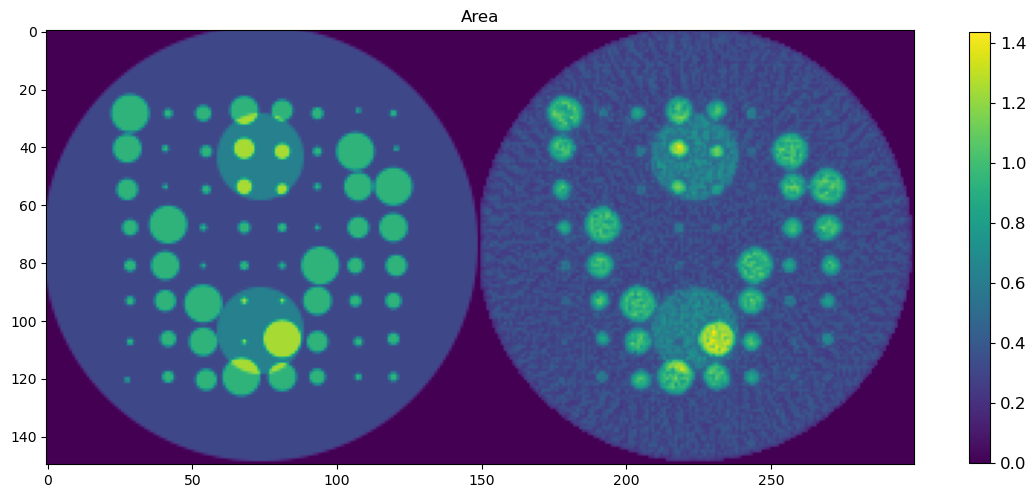

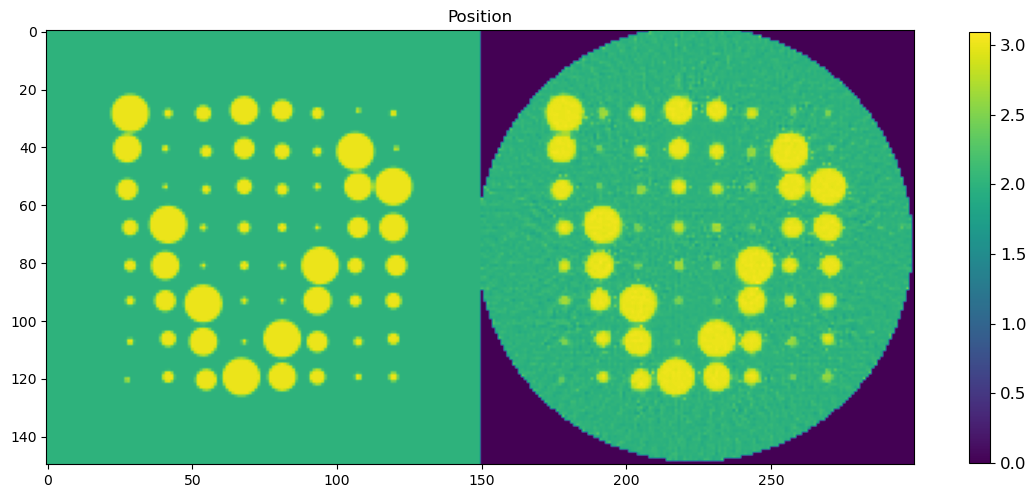

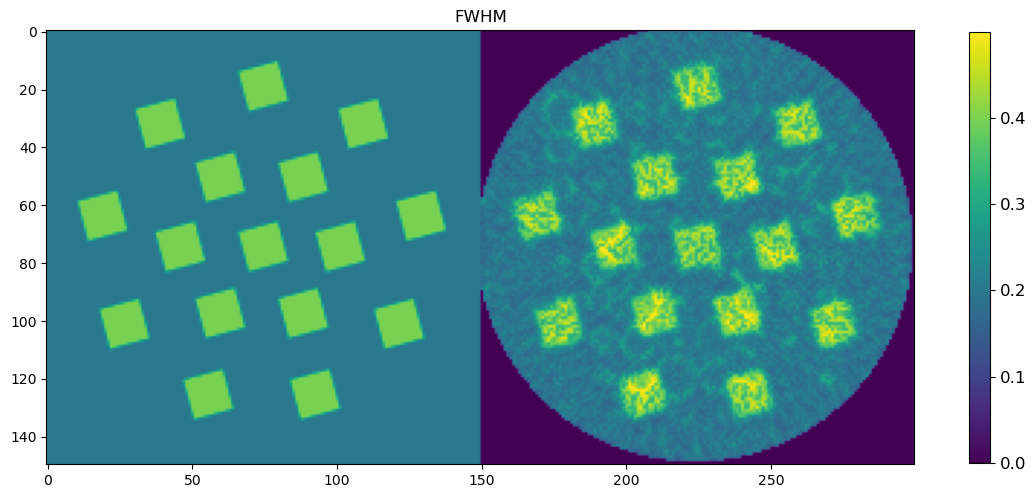

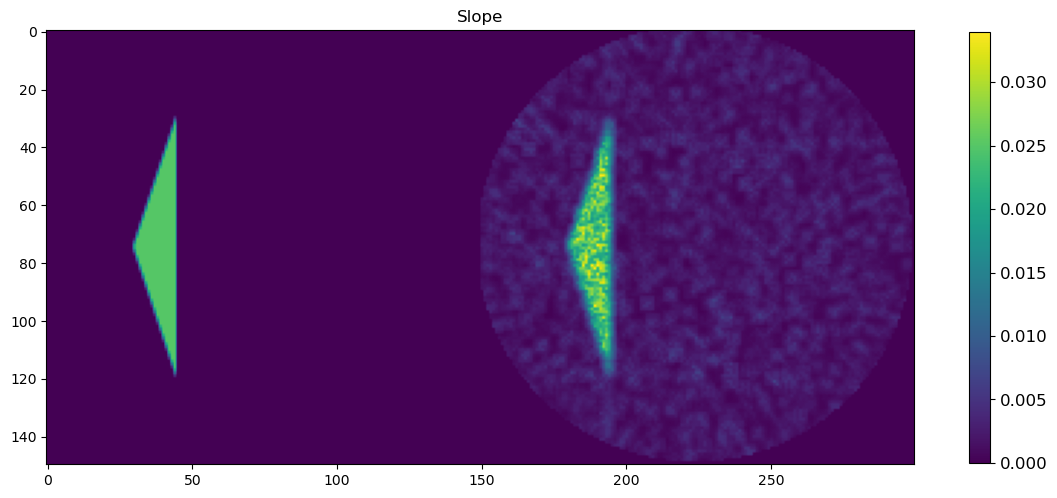

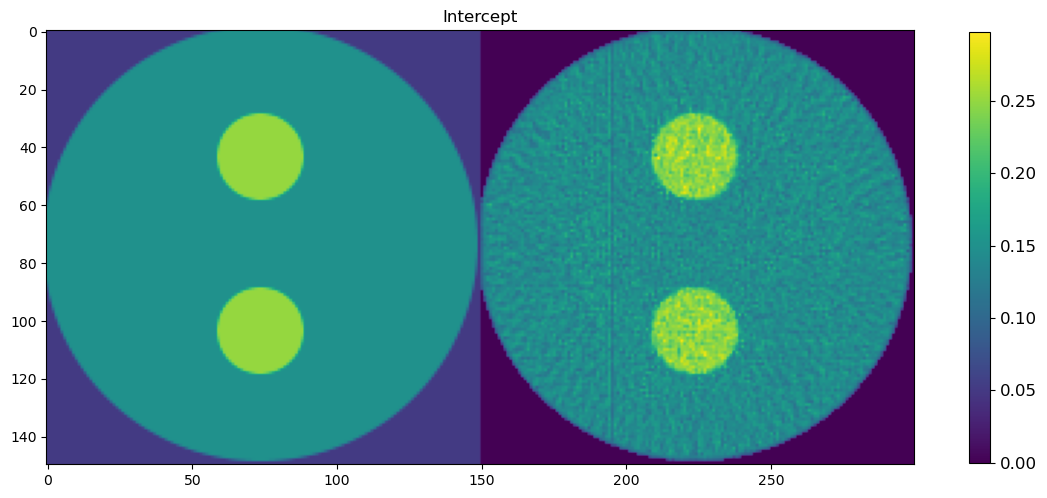

In [40]:
%matplotlib inline

ims = model(im_static)
filtered = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

prms_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
prms_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
prms_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((prms_peak1_area.shape[0] - peak_area.shape[0])/2)

prms_peak1_area = prms_peak1_area[ofs:prms_peak1_area.shape[0]-ofs, ofs:prms_peak1_area.shape[1]-ofs]
prms_peak1_pos = prms_peak1_pos[ofs:prms_peak1_pos.shape[0]-ofs, ofs:prms_peak1_pos.shape[1]-ofs]
prms_peak1_fwhm = prms_peak1_fwhm[ofs:prms_peak1_fwhm.shape[0]-ofs, ofs:prms_peak1_fwhm.shape[1]-ofs]
prms_slope = prms_slope[ofs:prms_slope.shape[0]-ofs, ofs:prms_slope.shape[1]-ofs]
prms_intercept = prms_intercept[ofs:prms_intercept.shape[0]-ofs, ofs:prms_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area, np.transpose(prms_peak1_area*msk)), axis = 1)
posc = np.concatenate((peak_position, np.transpose(prms_peak1_pos*msk)), axis = 1)
fwhmc = np.concatenate((peak_fwhm, np.transpose(prms_peak1_fwhm*msk)), axis = 1)
slopec = np.concatenate((peak_slope, np.transpose(prms_slope*msk)), axis = 1)
interceptc = np.concatenate((peak_intercept, np.transpose(prms_intercept*msk)), axis = 1)

plt.figure(1, figsize=(14,14));plt.clf()
h = plt.imshow(areac)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Area')
plt.show()

plt.figure(2, figsize=(14,14));plt.clf()
h = plt.imshow(posc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Position')
plt.show()

plt.figure(3, figsize=(14,14));plt.clf()
h = plt.imshow(fwhmc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(14,14));plt.clf()
h = plt.imshow(slopec)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(14,14));plt.clf()
h = plt.imshow(interceptc)
cbar = plt.colorbar(h, shrink=0.4)
cbar.ax.tick_params(labelsize=12)
plt.title('Intercept')
plt.show()

## 🧪 Final Comparison: Ground Truth vs FBP-Fit vs DLSR-prm vs DLSR-PeakFitCNN

We now present a unified side-by-side visual comparison of the parameter maps produced by:
1. **Ground Truth** — from the original synthetic phantom
2. **FBP + Peak Fitting** — fitted using `PrmCNN2D` on the FBP-reconstructed volume
3. **DLSR-prm** — fitted using `PrmCNN2D` using the DLSR approach with the sinogram data
4. **DLSR-PeakFitCNN** — directly predicted from 4× downsampled input using a self-supervised CNN

### 📌 Parameters Compared

- **Peak Area**
- **Peak Position**
- **Peak FWHM**
- **Background Slope**
- **Background Intercept**

Each subplot displays the four maps concatenated horizontally:
- **First**: Ground truth
- **Seconnd**: FBP + peak fit
- **Third**: DLSR-prm
- **Fourth**: DLSR-PeakFitCNN

### 🔍 Purpose

This visualization enables direct assessment of:
- **Spatial fidelity**: How well each method recovers sharp features and gradients
- **Noise resilience**: Suppression of artefacts, especially in low-signal regions
- **Biases or smoothing effects** from CNN regularization or FBP artefacts

By comparing all approaches under the same visualization layout, we can appreciate the strengths and weaknesses of each pipeline.

In the next and final section, we’ll summarize key findings and reflect on implications for real-world XRD-CT analysis and future directions.

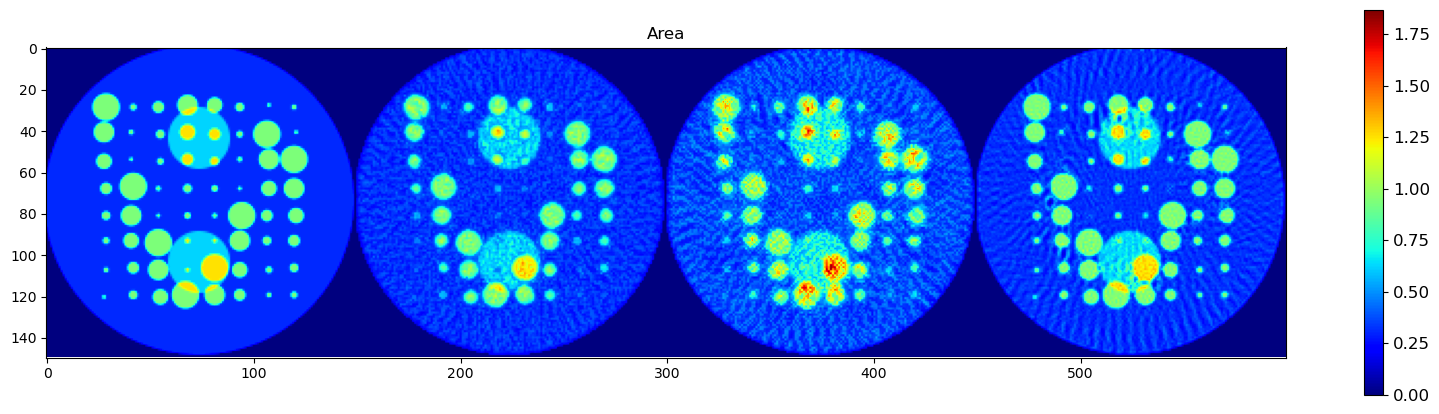

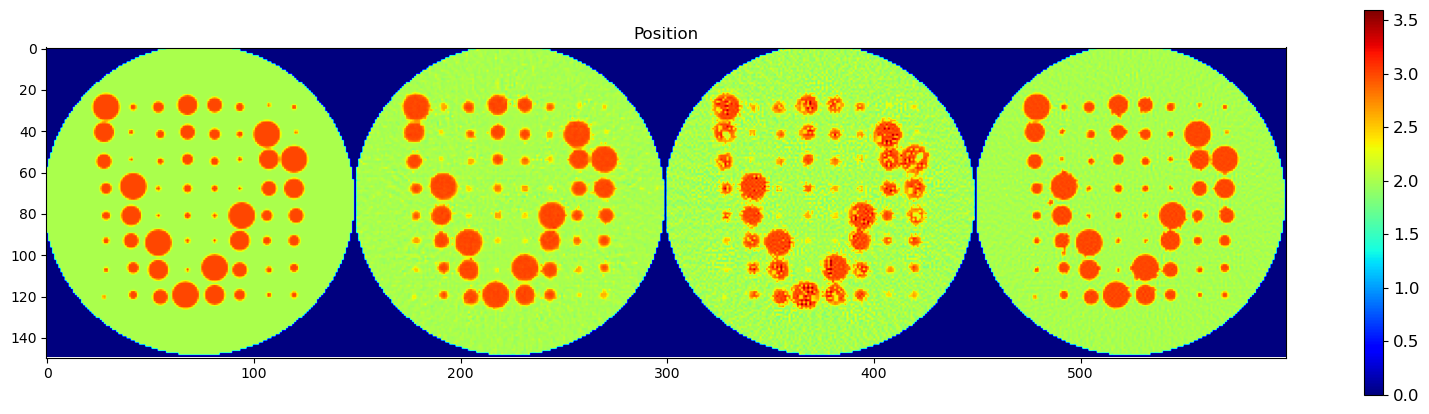

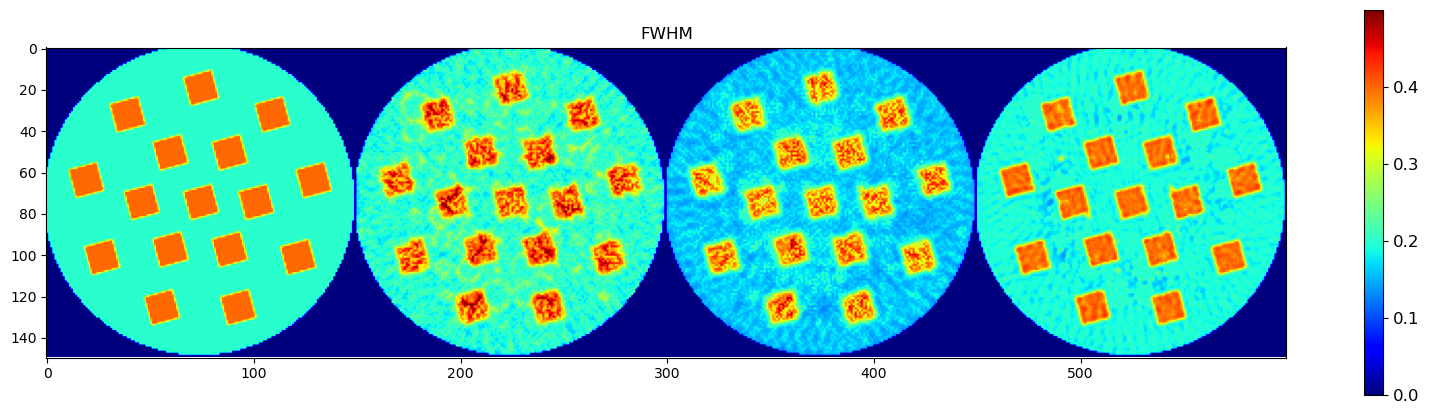

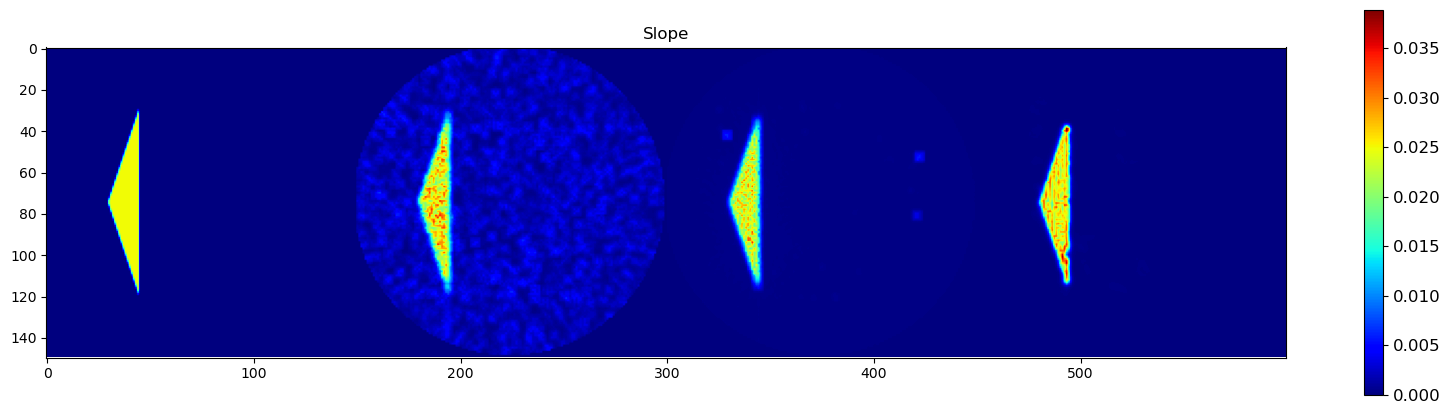

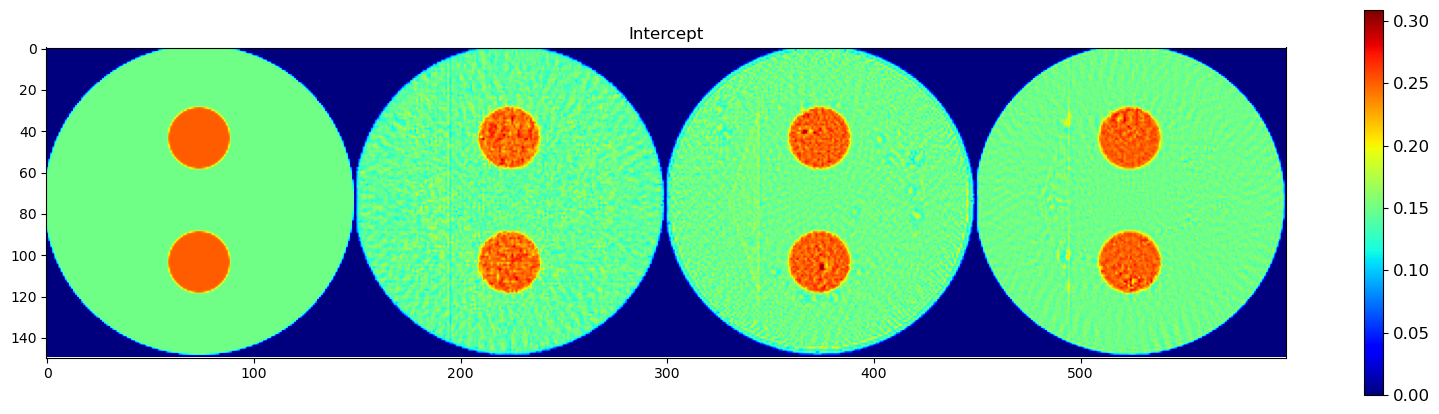

In [45]:
%matplotlib inline

ims = model_cnn(downsampled)

filtered = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)(ims)
lower_bound = filtered * (1 - prf)
upper_bound = filtered * (1 + prf)
ims = torch.clamp(ims, min=lower_bound, max=upper_bound)

i = 0

cnn_peak1_area = denormalize(ims[:, i * 3, :, :], 'Area', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_pos = denormalize(ims[:, i * 3 + 1, :, :], 'Position', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_peak1_fwhm = denormalize(ims[:, i * 3 + 2, :, :], 'FWHM', param_min, param_max, i)[0,:,:].cpu().detach().numpy()
cnn_slope = denormalize(ims[:, -2, :, :], 'Slope', param_min, param_max, )[0,:,:].cpu().detach().numpy()
cnn_intercept = denormalize(ims[:, -1, :, :], 'Intercept', param_min, param_max, )[0,:,:].cpu().detach().numpy()

ofs = int((cnn_peak1_area.shape[0] - peak_area.shape[0])/2)

cnn_peak1_area = cnn_peak1_area[ofs:cnn_peak1_area.shape[0]-ofs, ofs:cnn_peak1_area.shape[1]-ofs]
cnn_peak1_pos = cnn_peak1_pos[ofs:cnn_peak1_pos.shape[0]-ofs, ofs:cnn_peak1_pos.shape[1]-ofs]
cnn_peak1_fwhm = cnn_peak1_fwhm[ofs:cnn_peak1_fwhm.shape[0]-ofs, ofs:cnn_peak1_fwhm.shape[1]-ofs]
cnn_slope = cnn_slope[ofs:cnn_slope.shape[0]-ofs, ofs:cnn_slope.shape[1]-ofs]
cnn_intercept = cnn_intercept[ofs:cnn_intercept.shape[0]-ofs, ofs:cnn_intercept.shape[1]-ofs]

msk = np.copy(peak_area)
msk[msk<0.1] = 0
msk[msk>0] = 1

areac = np.concatenate((peak_area*msk, np.transpose(prms_peak1_area)*msk, prms_peak1_area_dlsr*msk, cnn_peak1_area*msk), axis = 1)
posc = np.concatenate((peak_position*msk, np.transpose(prms_peak1_pos)*msk, prms_peak1_pos_dlsr*msk,cnn_peak1_pos*msk), axis = 1)
fwhmc = np.concatenate((peak_fwhm*msk, np.transpose(prms_peak1_fwhm)*msk, prms_peak1_fwhm_dlsr*msk,cnn_peak1_fwhm*msk), axis = 1)
slopec = np.concatenate((peak_slope*msk, np.transpose(prms_slope)*msk, prms_slope_dlsr*msk,cnn_slope*msk), axis = 1)
interceptc = np.concatenate((peak_intercept*msk, np.transpose(prms_intercept)*msk, prms_intercept_dlsr*msk,cnn_intercept*msk), axis = 1)

plt.figure(1, figsize=(20,20));plt.clf()
h = plt.imshow(areac, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.25)
cbar.ax.tick_params(labelsize=12)
plt.title('Area')
plt.show()

plt.figure(2, figsize=(20,20));plt.clf()
h = plt.imshow(posc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.25)
cbar.ax.tick_params(labelsize=12)
plt.title('Position')
plt.show()

plt.figure(3, figsize=(20,20));plt.clf()
h = plt.imshow(fwhmc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.25)
cbar.ax.tick_params(labelsize=12)
plt.title('FWHM')
plt.show()

plt.figure(4, figsize=(20,20));plt.clf()
h = plt.imshow(slopec, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.25)
cbar.ax.tick_params(labelsize=12)
plt.title('Slope')
plt.show()

plt.figure(5, figsize=(20,20));plt.clf()
h = plt.imshow(interceptc, cmap = 'jet')
cbar = plt.colorbar(h, shrink=0.25)
cbar.ax.tick_params(labelsize=12)
plt.title('Intercept')
plt.show()

### 💾 Save Processed Parameter Maps to HDF5

To facilitate downstream analysis and reproducibility, we save all relevant parameter maps to an HDF5 file (`dlsr_results.h5`). This includes:

- **Ground truth maps** (`*_gt`) from the synthetic simulation  
- **DLSR-PeakFitCNN predictions** (`*_dlsr_cnn`) obtained from `PeakFitCNN`
- **DLSR-prm predictions** (`*_dlsr_prms`) obtained from `PrmCNN2D`
- **FBP-prm predictions** (`*_fbp_prms`) obtained from `PrmCNN2D`
- **Side-by-side concatenated maps** (`*_concat`) used for visualization  

All maps are masked (`msk`) to include only signal-rich regions. The file is stored in the `examples/results/` directory of the `nDTomo` package using a relative path resolved by `ndtomopath()`.

This step ensures a compact, structured format for easy sharing, reproducibility, and integration with other analysis or visualization tools.

In [46]:
import h5py, os
from nDTomo.methods.misc import ndtomopath

fn = os.path.join(ndtomopath(), 'examples', 'results', 'dlsr_results.h5')

with h5py.File(fn, 'w') as f:

    f.create_dataset('peak_area_gt', data=peak_area*msk)
    f.create_dataset('peak_area_dlsr_cnn', data=cnn_peak1_area*msk)
    f.create_dataset('peak_area_dlsr_prms', data=prms_peak1_area_dlsr*msk)
    f.create_dataset('peak_area_fbp_prms', data=prms_peak1_area*msk)

    f.create_dataset('peak_position_gt', data=peak_position*msk)
    f.create_dataset('peak_position_dlsr_cnn', data=cnn_peak1_pos*msk)
    f.create_dataset('peak_position_dlsr_prms', data=prms_peak1_pos_dlsr*msk)
    f.create_dataset('peak_position_fbp_prms', data=prms_peak1_pos*msk)

    f.create_dataset('peak_fwhm_gt', data=peak_fwhm*msk)
    f.create_dataset('peak_fwhm_dlsr_cnn', data=cnn_peak1_fwhm*msk)
    f.create_dataset('peak_fwhm_dlsr_prms', data=prms_peak1_fwhm_dlsr*msk)
    f.create_dataset('peak_fwhm_fbp_prms', data=prms_peak1_fwhm*msk)

    f.create_dataset('peak_slope_gt', data=peak_slope*msk)
    f.create_dataset('peak_slope_dlsr_cnn', data=cnn_slope*msk)
    f.create_dataset('peak_slope_dlsr_prms', data=prms_slope_dlsr*msk)
    f.create_dataset('peak_slope_fbp_prms', data=prms_slope*msk)

    f.create_dataset('peak_intercept_gt', data=peak_intercept*msk)
    f.create_dataset('peak_intercept_dlsr_cnn', data=cnn_intercept*msk)
    f.create_dataset('peak_intercept_dlsr_prms', data=prms_intercept_dlsr*msk)
    f.create_dataset('peak_intercept_fbp_prms', data=prms_intercept*msk)

    f.create_dataset('peak_area_concat', data=areac)
    f.create_dataset('peak_position_concat', data=posc)
    f.create_dataset('peak_fwhm_concat', data=fwhmc)
    f.create_dataset('peak_slope_concat', data=slopec)  
    f.create_dataset('peak_intercept_concat', data=interceptc)


### 📏 Define Evaluation Metrics

To quantitatively compare the CNN-predicted and conventionally fitted parameter maps against the ground truth, we implement the following standard image quality metrics using NumPy and `scikit-image`:

- **MAE (Mean Absolute Error):**  
  Measures the average absolute difference between the predicted and ground truth values.

- **MSE (Mean Squared Error):**  
  Measures the average of the squared differences, penalizing larger errors more heavily.

- **RMSE (Root Mean Squared Error):**  
  The square root of MSE. While MSE penalizes larger errors more heavily due to squaring, RMSE transforms the result back to the original data scale, making it easier to interpret. It retains the sensitivity to large errors but is more directly comparable to the magnitude of the target values.

- **PSNR (Peak Signal-to-Noise Ratio):**  
  Indicates the ratio between the maximum possible signal and the noise introduced by prediction errors. Higher values imply better fidelity.

- **SSIM (Structural Similarity Index):**
  Evaluates perceived quality by comparing local patterns of pixel intensities. It accounts for luminance, contrast, and structural differences.


In [78]:
import numpy as np
from skimage.metrics import structural_similarity as ssim_skimage

def mae(gt, pred):
    return np.mean(np.abs(gt - pred))

def mse(gt, pred):
    return np.mean((gt - pred)**2)

def rmse(gt, pred):
    return np.sqrt(mse(gt, pred))

def psnr(gt, pred, data_range=None):
    if data_range is None:
        data_range = gt.max() - gt.min()
    return 20 * np.log10(data_range) - 10 * np.log10(mse(gt, pred))

def ssim(gt, pred, data_range=None):
    if data_range is None:
        data_range = gt.max() - gt.min()
    return ssim_skimage(gt, pred, data_range=data_range)


def plot_results(gt, cnn, prms_dlsr, prms, label, folder=None):

    if folder is None:
        folder = os.path.join(ndtomopath(), 'examples', 'results')

    mae_vals = [
        mae(gt, cnn),
        mae(gt, prms_dlsr),
        mae(gt, prms)
    ]

    ssim_vals = [
        ssim(gt, cnn),
        ssim(gt, prms_dlsr),
        ssim(gt, prms)
    ]

    mse_vals = [
        mse(gt, cnn),
        mse(gt, prms_dlsr),
        mse(gt, prms)
    ]

    rmse_vals = [
        rmse(gt, cnn),
        rmse(gt, prms_dlsr),
        rmse(gt, prms)
    ]

    psnr_vals = [
        psnr(gt, cnn),
        psnr(gt, prms_dlsr),
        psnr(gt, prms)
    ]

    # Labels
    methods = ['DLSR-PeakFitCNN', 'DLSR-prms', 'FBP-prms']
    metrics = ['MAE', 'SSIM', 'MSE', 'RMSE', 'PSNR']
    all_metrics = [mae_vals, ssim_vals, mse_vals, rmse_vals, psnr_vals]

    # Plot each metric in a separate figure
    for i, (metric_name, values) in enumerate(zip(metrics, all_metrics)):
        plt.figure(figsize=(6, 5))
        bars = plt.bar(methods, values)
        
        # Annotate bars with values
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.6f}',
                    ha='center', va='bottom', fontsize=10)
        
        plt.ylabel(metric_name)
        plt.title(f'{label} {metric_name} Comparison')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(os.path.join(folder, f'{label}_{metric_name}_dlsr.png'), dpi=300)
        plt.show()


CNN MAE: 0.032880998292062515
PRMS DLSR MAE: 0.07094472231544013
PRMS MAE: 0.10637854429075828
----------
CNN SSIM: 0.7631768138539838
PRMS DLSR SSIM: 0.5974951999440254
PRMS SSIM: 0.47537739079722724
----------
CNN MSE: 0.0025517945926493246
PRMS DLSR MSE: 0.011779700975874498
PRMS MSE: 0.04090083879385902
----------
CNN RMSE: 0.05051529068162752
PRMS DLSR RMSE: 0.10853433086297855
PRMS RMSE: 0.20223955793528384
----------
CNN PSNR: 27.869743132041453
PRMS DLSR PSNR: 21.22685759858403
PRMS PSNR: 15.82087811411973


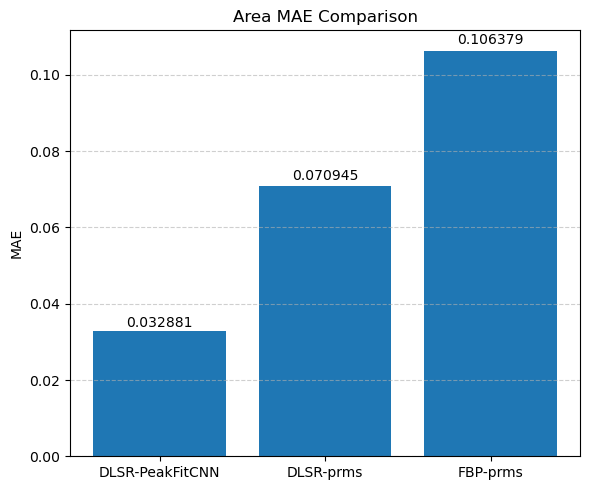

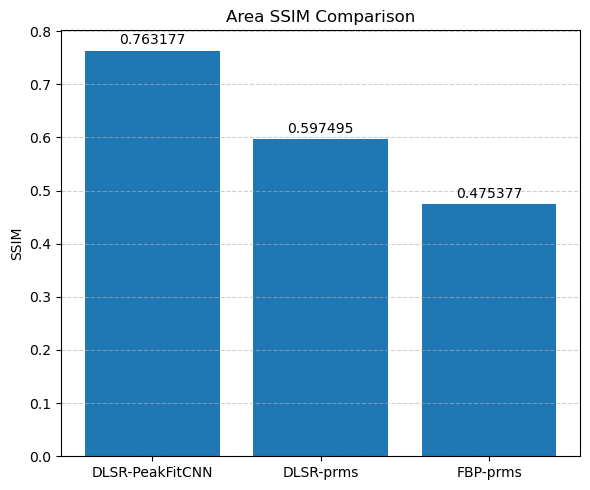

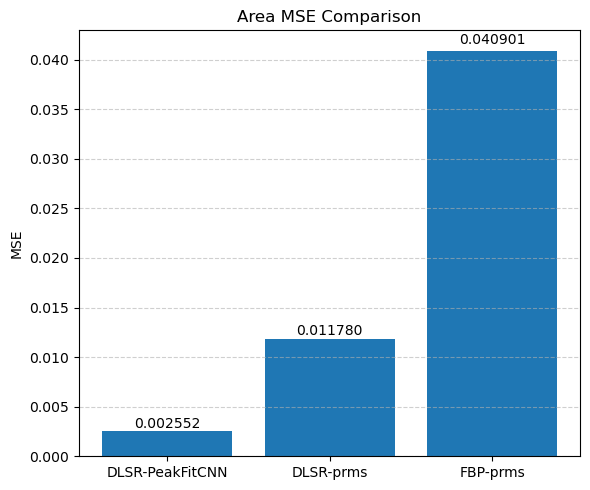

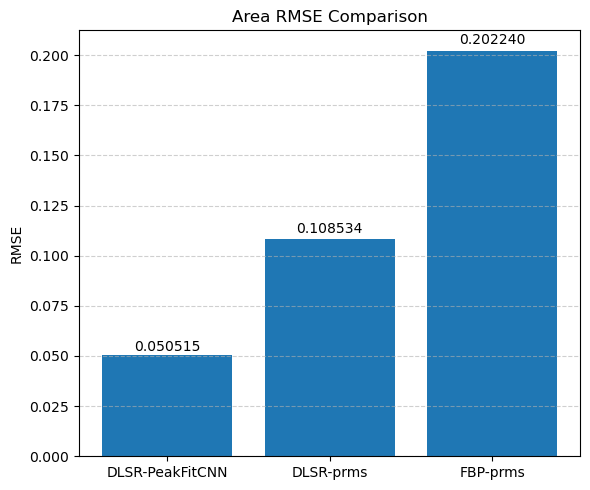

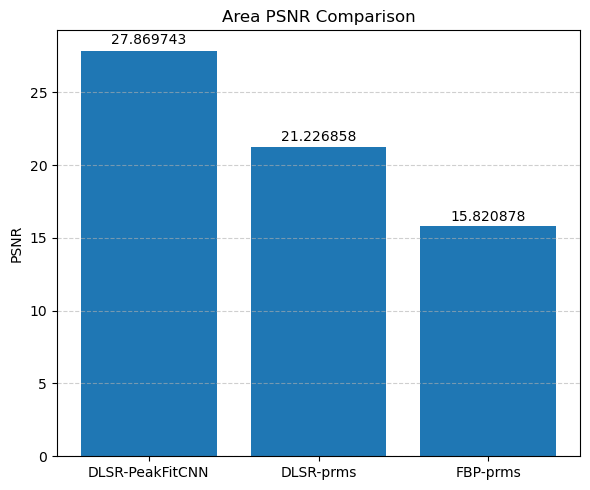

In [79]:
gt = peak_area * msk
cnn = cnn_peak1_area * msk
prms_dlsr = prms_peak1_area_dlsr * msk
prms = prms_peak1_area * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS DLSR MAE:", mae(gt, prms_dlsr))
print("PRMS MAE:", mae(gt, prms))
print('----------')
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS DLSR SSIM:", ssim(gt, prms_dlsr))
print("PRMS SSIM:", ssim(gt, prms))
print('----------')
print("CNN MSE:", mse(gt, cnn))
print("PRMS DLSR MSE:", mse(gt, prms_dlsr))
print("PRMS MSE:", mse(gt, prms))
print('----------')
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS DLSR RMSE:", rmse(gt, prms_dlsr))
print("PRMS RMSE:", rmse(gt, prms))
print('----------')
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS DLSR PSNR:", psnr(gt, prms_dlsr))
print("PRMS PSNR:", psnr(gt, prms))

plot_results(gt, cnn, prms_dlsr, prms, label='Area')


CNN MAE: 0.037078241829813265
PRMS DLSR MAE: 0.09985590337627709
PRMS MAE: 0.13296028588554007
----------
CNN SSIM: 0.880240597746252
PRMS DLSR SSIM: 0.6534935643442704
PRMS SSIM: 0.6355206333235536
----------
CNN MSE: 0.004254889381996164
PRMS DLSR MSE: 0.025488439627958902
PRMS MSE: 0.09089050909190784
----------
CNN RMSE: 0.06522951312094982
PRMS DLSR RMSE: 0.1596509931944017
PRMS RMSE: 0.30148052854522434
----------
CNN PSNR: 33.253542355975995
PRMS DLSR PSNR: 25.478992601493253
PRMS PSNR: 19.95723973458388


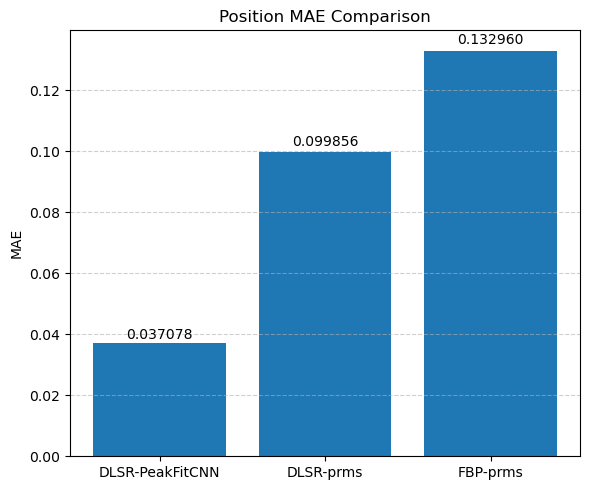

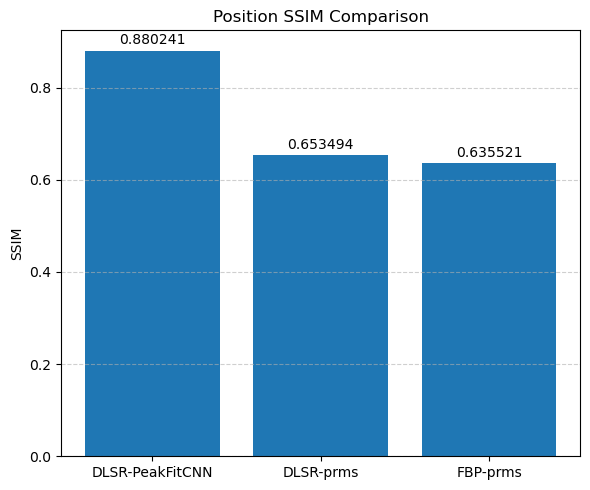

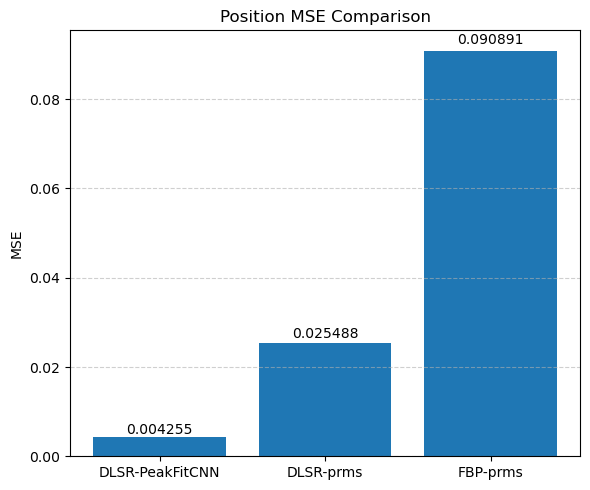

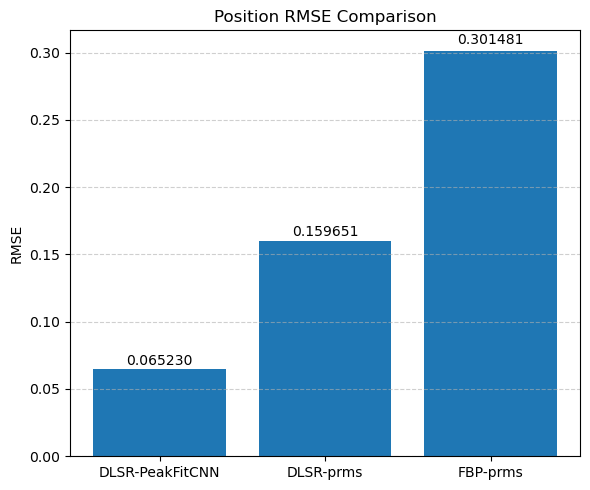

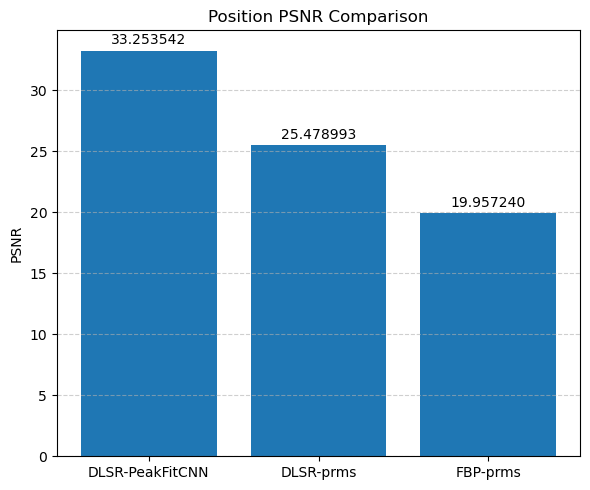

In [80]:
gt = peak_position * msk
cnn = cnn_peak1_pos * msk
prms_dlsr = prms_peak1_pos_dlsr * msk
prms = prms_peak1_pos * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS DLSR MAE:", mae(gt, prms_dlsr))
print("PRMS MAE:", mae(gt, prms))
print('----------')
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS DLSR SSIM:", ssim(gt, prms_dlsr))
print("PRMS SSIM:", ssim(gt, prms))
print('----------')
print("CNN MSE:", mse(gt, cnn))
print("PRMS DLSR MSE:", mse(gt, prms_dlsr))
print("PRMS MSE:", mse(gt, prms))
print('----------')
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS DLSR RMSE:", rmse(gt, prms_dlsr))
print("PRMS RMSE:", rmse(gt, prms))
print('----------')
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS DLSR PSNR:", psnr(gt, prms_dlsr))
print("PRMS PSNR:", psnr(gt, prms))

plot_results(gt, cnn, prms_dlsr, prms, label='Position')

CNN MAE: 0.009734031967542793
PRMS DLSR MAE: 0.029672065857338975
PRMS MAE: 0.05247869552229657
----------
CNN SSIM: 0.7873608882599813
PRMS DLSR SSIM: 0.6535973294229542
PRMS SSIM: 0.3131377568093183
----------
CNN MSE: 0.00021778565586626588
PRMS DLSR MSE: 0.0014917452992159756
PRMS MSE: 0.008195099691559663
----------
CNN RMSE: 0.014757562666858843
PRMS DLSR RMSE: 0.038623118714262
PRMS RMSE: 0.09052678991083062
----------
CNN PSNR: 28.660907104651628
PRMS DLSR PSNR: 20.30425304685309
PRMS PSNR: 12.905657416217792


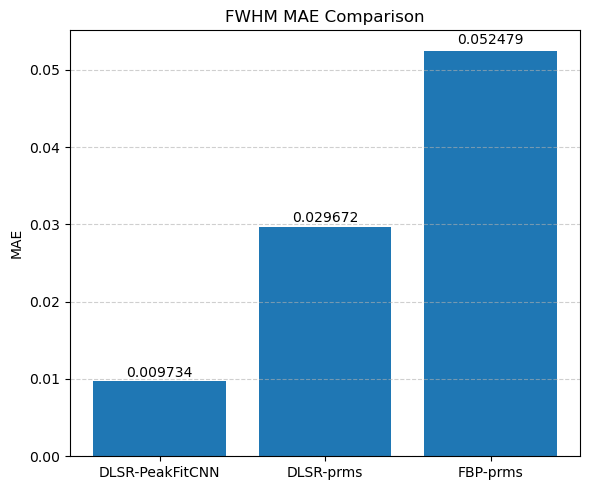

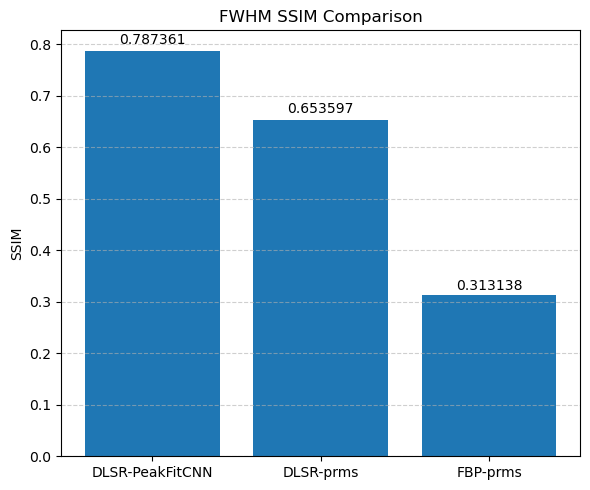

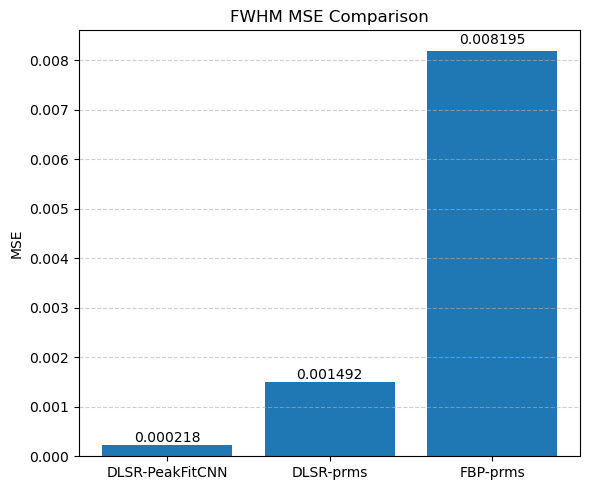

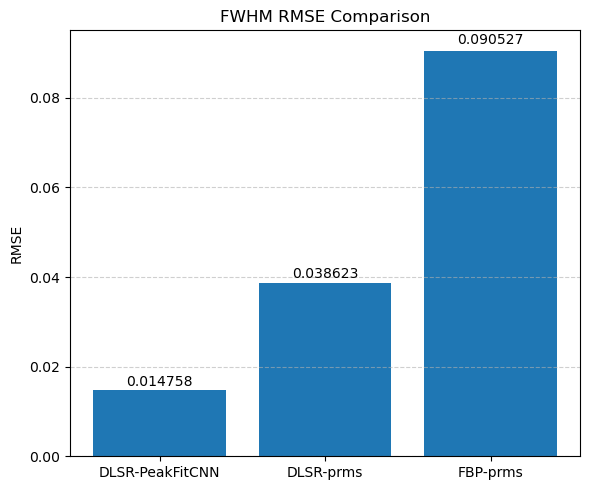

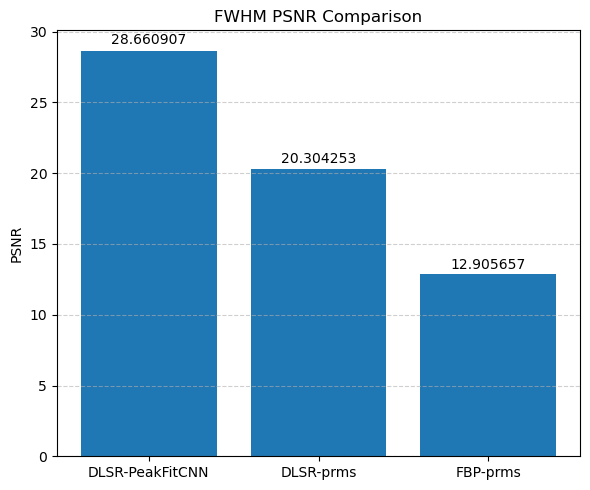

In [81]:
gt = peak_fwhm * msk
cnn = cnn_peak1_fwhm * msk
prms_dlsr = prms_peak1_fwhm_dlsr * msk
prms = prms_peak1_fwhm * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS DLSR MAE:", mae(gt, prms_dlsr))
print("PRMS MAE:", mae(gt, prms))
print('----------')
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS DLSR SSIM:", ssim(gt, prms_dlsr))
print("PRMS SSIM:", ssim(gt, prms))
print('----------')
print("CNN MSE:", mse(gt, cnn))
print("PRMS DLSR MSE:", mse(gt, prms_dlsr))
print("PRMS MSE:", mse(gt, prms))
print('----------')
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS DLSR RMSE:", rmse(gt, prms_dlsr))
print("PRMS RMSE:", rmse(gt, prms))
print('----------')
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS DLSR PSNR:", psnr(gt, prms_dlsr))
print("PRMS PSNR:", psnr(gt, prms))

plot_results(gt, cnn, prms_dlsr, prms, label='FWHM')

CNN MAE: 0.0002011942187838696
PRMS DLSR MAE: 0.0004251532707203293
PRMS MAE: 0.002878232941822127
----------
CNN SSIM: 0.9452899580886321
PRMS DLSR SSIM: 0.5821262562207158
PRMS SSIM: 0.1345862439554213
----------
CNN MSE: 1.199620708520884e-06
PRMS DLSR MSE: 1.7387319958491733e-06
PRMS MSE: 3.512748112242048e-05
----------
CNN RMSE: 0.0010952719792457414
PRMS DLSR RMSE: 0.001318609872497993
PRMS RMSE: 0.005926844111533597
----------
CNN PSNR: 27.168360631586182
PRMS DLSR PSNR: 25.556473713353967
PRMS PSNR: 12.502330082823008


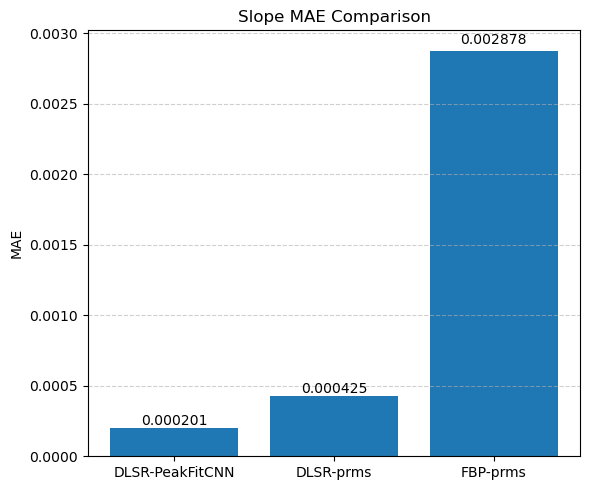

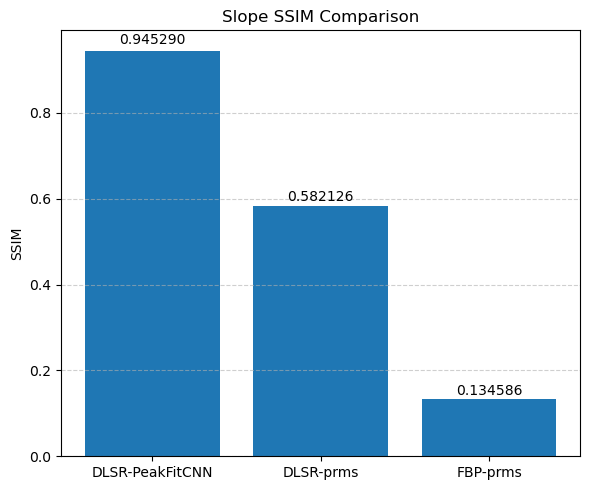

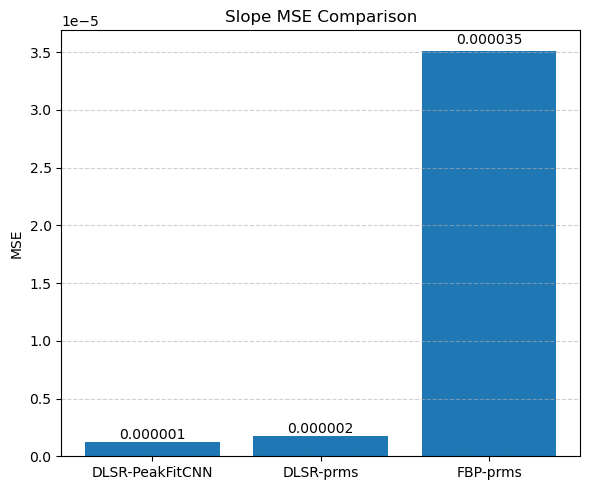

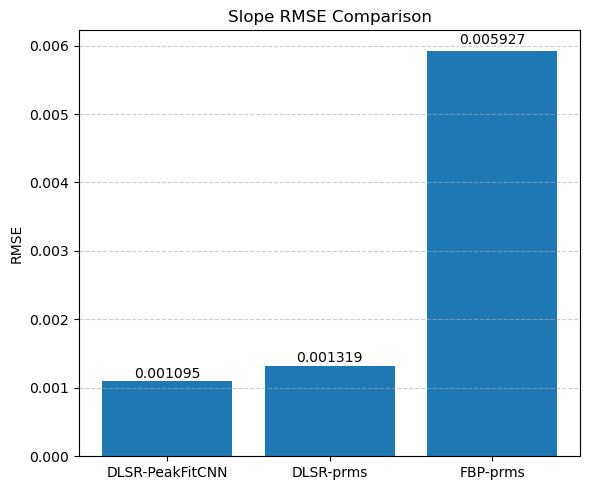

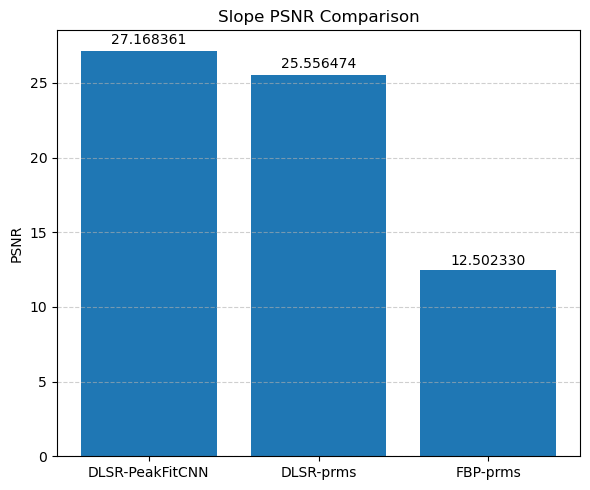

In [82]:
gt = peak_slope * msk
cnn = cnn_slope * msk
prms_dlsr = prms_slope_dlsr * msk
prms = prms_slope * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS DLSR MAE:", mae(gt, prms_dlsr))
print("PRMS MAE:", mae(gt, prms))
print('----------')
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS DLSR SSIM:", ssim(gt, prms_dlsr))
print("PRMS SSIM:", ssim(gt, prms))
print('----------')
print("CNN MSE:", mse(gt, cnn))
print("PRMS DLSR MSE:", mse(gt, prms_dlsr))
print("PRMS MSE:", mse(gt, prms))
print('----------')
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS DLSR RMSE:", rmse(gt, prms_dlsr))
print("PRMS RMSE:", rmse(gt, prms))
print('----------')
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS DLSR PSNR:", psnr(gt, prms_dlsr))
print("PRMS PSNR:", psnr(gt, prms))

plot_results(gt, cnn, prms_dlsr, prms, label='Slope')

CNN MAE: 0.005857232838535097
PRMS DLSR MAE: 0.009264647091086672
PRMS MAE: 0.020826641719806915
----------
CNN SSIM: 0.6136655625582432
PRMS DLSR SSIM: 0.4771903437150229
PRMS SSIM: 0.3741221403784698
----------
CNN MSE: 7.792827423047736e-05
PRMS DLSR MSE: 0.00019009746708220906
PRMS MSE: 0.001414121818277489
----------
CNN RMSE: 0.00882769926030998
PRMS DLSR RMSE: 0.013787583801457347
PRMS RMSE: 0.03760481110546214
----------
CNN PSNR: 29.041849587165906
PRMS DLSR PSNR: 25.16903687114867
PRMS PSNR: 16.453931943563802


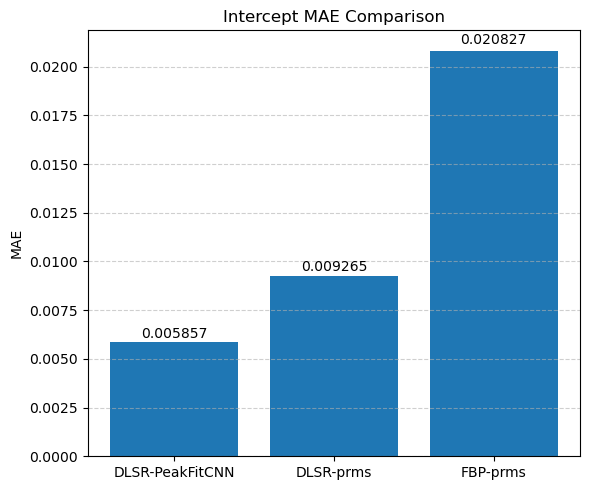

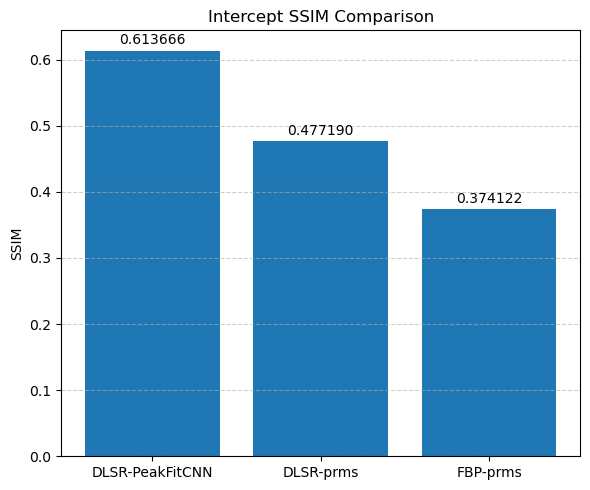

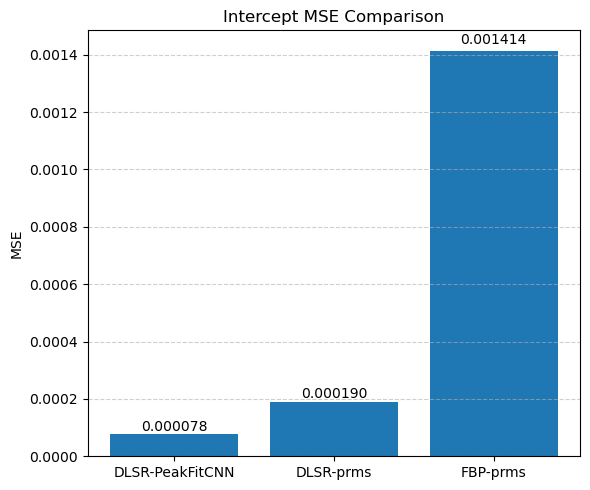

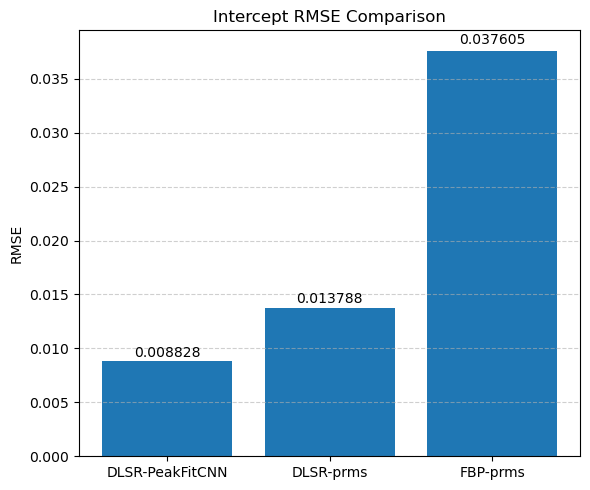

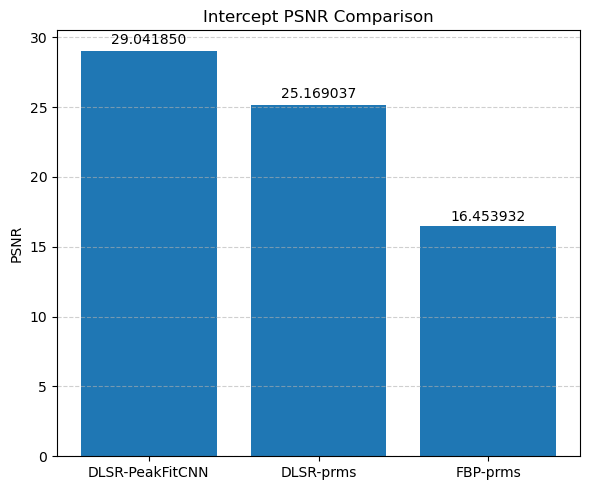

In [83]:
gt = peak_intercept * msk
cnn = cnn_intercept * msk
prms_dlsr = prms_intercept_dlsr * msk
prms = prms_intercept * msk

print("CNN MAE:", mae(gt, cnn))
print("PRMS DLSR MAE:", mae(gt, prms_dlsr))
print("PRMS MAE:", mae(gt, prms))
print('----------')
print("CNN SSIM:", ssim(gt, cnn))
print("PRMS DLSR SSIM:", ssim(gt, prms_dlsr))
print("PRMS SSIM:", ssim(gt, prms))
print('----------')
print("CNN MSE:", mse(gt, cnn))
print("PRMS DLSR MSE:", mse(gt, prms_dlsr))
print("PRMS MSE:", mse(gt, prms))
print('----------')
print("CNN RMSE:", rmse(gt, cnn))
print("PRMS DLSR RMSE:", rmse(gt, prms_dlsr))
print("PRMS RMSE:", rmse(gt, prms))
print('----------')
print("CNN PSNR:", psnr(gt, cnn))
print("PRMS DLSR PSNR:", psnr(gt, prms_dlsr))
print("PRMS PSNR:", psnr(gt, prms))

plot_results(gt, cnn, prms_dlsr, prms, label='Intercept')

## ✅ Final Remarks and Outlook

In this notebook, we explored and compared three distinct strategies for reconstructing peak parameter maps from hyperspectral XRD-CT data under angular undersampling conditions:

### 🧪 Summary of Approaches

| Method | Input | Output | Optimization |
|--------|-------|--------|--------------|
| **FBP + Peak Fitting** | N/A | Parameter maps | Peak fitting using the reconstructed volume |
| **DLSR-prm** | N/A | Parameter maps | Peak fitting and reconstruction of the parameter maps using the sinogram data |
| **DLSR-PeakFitCNN** | Downsampled hyperspectral volume | Parameter maps | Peak fitting and reconstruction of the parameter maps using the sinogram data with a self-supervised neural network |

### 📊 Key Findings

- **DLSR-prm** provides physically consistent reconstructions and shows some resilience to angular undersampling but the how one imposes constraints and regularisation can change the results significantly.
- **DLSR-PeakFitCNN** performs surprisingly well, achieving smooth and accurate maps with fewer learnable parameters and faster convergence. It benefits from spatial regularization via convolution.
- **FBP + Peak Fitting** shows reasonable accuracy but is sensitive to FBP artefacts, especially near boundaries or in low-signal regions. Its performance degrades more noticeably under sparse sampling.

### 💡 Contributions

- First **open-source PyTorch-based implementation** of the DLSR framework for XRD-CT
- Demonstrated the feasibility of using **neural networks instead of parameter maps** in DLSR
- Introduced **self-supervised CNN peak fitting** as a lightweight alternative, requiring no ground truth labels
- Provided a modular, reproducible benchmarking framework for XRD-CT reconstruction pipelines

### 🔭 Future Directions

- Extend to **multi-peak** and **asymmetric peak shapes** (e.g., Pseudo-Voigt or split-Voigt)
- Apply to **real experimental datasets**, especially where parallax or low-angle artefacts dominate
- Combine DLSR and CNN strategies in **hybrid architectures**, e.g., CNN-based priors in physics-constrained models

This work lays the groundwork for robust, interpretable, and scalable peak fitting in next-generation XRD-CT datasets. The integration of physics-based modeling and deep learning opens exciting opportunities for real-time, high-fidelity chemical imaging.